In [ ]:
import os
import numpy as np
from PIL import Image
import pandas as pd


import torch
import torch.nn.functional as F

def to_tensor(x):
    if isinstance(x, np.ndarray): x = torch.from_numpy(x)
    return x.float()

def ensure_BTCHW(x):
    if x.ndim == 3:  # [T,H,W]
        x = x.unsqueeze(0).unsqueeze(2)
    elif x.ndim == 4:  # [B,T,H,W]
        x = x.unsqueeze(2)
    return x

def pool8(x):
    B,T,C,H,W = x.shape
    y = F.avg_pool2d(x.reshape(B*T, C, H, W), kernel_size=8, stride=8)
    return y.view(B, T, C, y.shape[-2], y.shape[-1])

# --- SSIM 與 tSSIM 公用函式 ---

def ssim2d(a, b, C1=0.01**2, C2=0.03**2):
    # a, b: 2D tensor (H, W), 已在 0-1 區間更佳；若不是請先正規化
    mu_a, mu_b = a.mean(), b.mean()
    sig_a = ((a - mu_a)**2).mean()
    sig_b = ((b - mu_b)**2).mean()
    sig_ab = ((a - mu_a) * (b - mu_b)).mean()
    num = (2*mu_a*mu_b + C1) * (2*sig_ab + C2)
    den = (mu_a**2 + mu_b**2 + C1) * (sig_a + sig_b + C2)
    return num / den

def _tssim_series(x, lag: int):
    """
    x: tensor [B, T, C, H, W]（經 ensure_BTCHW() 後）
    lag: 與過去第 lag 幀做 SSIM（t 對 t-lag）
    回傳：tensor [B, T-lag]（每個 batch、每個有效時間點的 tSSIM）
    """
    assert lag >= 1, "lag 必須 >= 1"
    vals = []
    # 只在 t >= lag 的時間點計算
    for t in range(lag, x.shape[1]):
        lst = [ssim2d(x[b, t, 0], x[b, t - lag, 0]) for b in range(x.shape[0])]
        # 與 x 同 dtype/device；避免跨裝置與精度問題
        vals.append(torch.tensor(lst, dtype=x.dtype, device=x.device))
    # [T-lag, B] -> [B, T-lag]
    return torch.stack(vals, dim=0).T


def delta_tssim(A, B, lag: int = 1, use_pool8: bool = True) -> float:
    """
    ΔtSSIM_lag = mean( tSSIM(A, lag) - tSSIM(B, lag) )
    A, B 可為 numpy 或 torch，shape 與 ensure_BTCHW 規則一致。
    """
    A = ensure_BTCHW(to_tensor(A))
    B = ensure_BTCHW(to_tensor(B))
    if use_pool8:
        A = pool8(A)
        B = pool8(B)
    tA = _tssim_series(A, lag)  # [B, T-lag]
    tB = _tssim_series(B, lag)  # [B, T-lag]
    return float((tA - tB).mean())


def ssim_spatial(A, B, use_pool8: bool = True) -> float:
    """
    空間 SSIM：逐幀計算 SSIM(A[b,t], B[b,t])，再對 B 與 T 取平均。
    """
    A = ensure_BTCHW(to_tensor(A))
    B = ensure_BTCHW(to_tensor(B))
    if use_pool8:
        A = pool8(A)
        B = pool8(B)
    Bsz, T = A.shape[0], A.shape[1]
    vals = []
    for b in range(Bsz):
        for t in range(T):
            vals.append(ssim2d(A[b, t, 0], B[b, t, 0]))
    return float(torch.stack(vals).mean())

def transform(output):
    # 你的特殊轉換
    return 10 ** (output * 0.0625) * 0.036

def load_imgs(folder, event_range=range(20)):
    frames = []
    for event_id in event_range:
        folder_event = os.path.join(folder, f"rain{event_id}")
        files = sorted(
            [f for f in os.listdir(folder_event) if f.lower().endswith('.png')],
            key=lambda x: int(os.path.splitext(x)[0])
        )
        for fname in files:
            img = Image.open(os.path.join(folder_event, fname)).convert('L')

            # 裁切中間 123x123
            # w, h = img.size  # 應該是 (128, 128)
            # left = (w - 123) // 2
            # top = (h - 123) // 2
            # right = left + 123
            # bottom = top + 123
            # img = img.crop((left, top, right, bottom))

            arr = np.array(img).astype(np.float32) / 3.0
            arr = transform(arr)  # 應用你的轉換
            frames.append(arr)
    return np.stack(frames)   # [n_frames, 123, 123]

def mae(pred, gt):
    return np.mean(np.abs(pred - gt))

def rmse(pred, gt):
    return np.sqrt(np.mean((pred - gt) ** 2))

def tgd(pred, gt):
    # pred, gt shape: [n_frames, H, W]
    delta_pred = np.diff(pred, axis=0)
    delta_gt = np.diff(gt, axis=0)
    return np.mean(np.abs(delta_pred - delta_gt))

def cprs(pred, gt):
    # 以像素空間皮爾森相關係數為例
    pred_flat = pred.flatten()
    gt_flat = gt.flatten()
    corr = np.corrcoef(pred_flat, gt_flat)[0, 1]
    return corr


# ==== 修改這裡為你的兩個資料夾 ====

# 你原本的 folders
folders = [
    r"C:\Users\n2000\Downloads\Evaluation\figs\interpolation_radar_event_val_20\a_radar_vaild",
    r"C:\Users\n2000\Downloads\Evaluation\figs\interpolation_radar_event_val_20\sti_base_val",
    r"C:\Users\n2000\Downloads\Evaluation\figs\interpolation_radar_event_val_20\sti_basepos_val",
    r"C:\Users\n2000\Downloads\Evaluation\figs\interpolation_radar_event_val_20\sti_baseposshock_val",
    r"C:\Users\n2000\Downloads\Evaluation\figs\interpolation_radar_event_val_20\sti_dk_val",
    r"C:\Users\n2000\Downloads\Evaluation\figs\interpolation_radar_event_val_20\sti_stdk_val",
    r"C:\Users\n2000\Downloads\Evaluation\figs\interpolation_radar_event_val_20\c_ok",
    r"C:\Users\n2000\Downloads\Evaluation\figs\interpolation_radar_event_val_20\c_rbf"
]

# Ground truth
folder_B = folders[0]  # a_radar_vaild
B = load_imgs(folder_B)

# 用來存結果
results = []

# 循環跑每個 folder（跳過 ground truth 本身）
for folder_A in folders[1:]:
    A = load_imgs(folder_A)
    assert A.shape == B.shape, f"{os.path.basename(folder_A)} 數量或 shape 不一致！"

    mae_score = mae(A, B)
    rmse_score = rmse(A, B)
    cprs_score = cprs(A, B)

    d_tssim_lag1 = delta_tssim(A, B, lag=1)   # ΔtSSIM_lag1
    d_tssim_lag2 = delta_tssim(A, B, lag=2)   # ΔtSSIM_lag2
    ssim_xy      = ssim_spatial(A, B)         # 空間 SSIM

    metrics = {
        "Folder": os.path.basename(folder_A),
        "MAE": round(mae_score, 4),
        "RMSE": round(rmse_score, 4),
        "CPRS": round(cprs_score, 4),
        "SSIM": round(ssim_xy, 4),
        "ΔtSSIM_lag1": round(d_tssim_lag1, 4),
        "ΔtSSIM_lag2": round(d_tssim_lag2, 4),
    }

    results.append(metrics)

# 整理成 DataFrame
df = pd.DataFrame(results)
print(df)

In [2]:
import os
import numpy as np
from PIL import Image

def transform(output):
    # 你的特殊轉換
    return 10 ** (output * 0.0625) * 0.036

def load_imgs_pairwise(folder_A, folder_B, event_range=range(20)):
    frames_A = []
    frames_B = []
    for event_id in event_range:
        folder_A_event = os.path.join(folder_A, f"rain{event_id}")
        folder_B_event = os.path.join(folder_B, f"rain{event_id}")
        files_A = sorted([f for f in os.listdir(folder_A_event) if f.lower().endswith('.png')],
                         key=lambda x: int(os.path.splitext(x)[0]))
        files_B = sorted([f for f in os.listdir(folder_B_event) if f.lower().endswith('.png')],
                         key=lambda x: int(os.path.splitext(x)[0]))
        n = min(len(files_A), len(files_B))
        if n == 0:
            print(f"rain{event_id} 沒有可用影像，跳過")
            continue
        for i in range(n):
            # A
            img_A = Image.open(os.path.join(folder_A_event, files_A[i])).convert('L')
            w, h = img_A.size
            left = (w - 126) // 2
            top = (h - 126) // 2
            right = left + 126
            bottom = top + 126
            img_A = img_A.crop((left, top, right, bottom))
            arr_A = np.array(img_A).astype(np.float32) / 3.0
            arr_A = transform(arr_A)
            frames_A.append(arr_A)

            # B
            img_B = Image.open(os.path.join(folder_B_event, files_B[i])).convert('L')
            w, h = img_B.size
            left = (w - 126) // 2
            top = (h - 126) // 2
            right = left + 126
            bottom = top + 126
            img_B = img_B.crop((left, top, right, bottom))
            arr_B = np.array(img_B).astype(np.float32) / 3.0
            arr_B = transform(arr_B)
            frames_B.append(arr_B)

    return np.stack(frames_A), np.stack(frames_B)


def categorical_metrics(pred, gt, threshold):
    # pred, gt: [n_frames, H, W]
    pred_bin = (pred >= threshold)
    gt_bin = (gt >= threshold)
    hits = np.logical_and(pred_bin, gt_bin).sum()
    misses = np.logical_and(~pred_bin, gt_bin).sum()
    false_alarms = np.logical_and(pred_bin, ~gt_bin).sum()
    correct_negatives = np.logical_and(~pred_bin, ~gt_bin).sum()
    POD = hits / (hits + misses + 1e-10)
    FAR = false_alarms / (hits + false_alarms + 1e-10)
    CSI = hits / (hits + misses + false_alarms + 1e-10)
    N = hits + misses + false_alarms + correct_negatives
    if N > 0:
        HSS = 2 * (hits * correct_negatives - misses * false_alarms) / (
            (misses**2 + false_alarms**2 + 2 * hits * correct_negatives +
             (misses + false_alarms) * (hits + correct_negatives) + 1e-10)
        )
    else:
        HSS = np.nan
    return POD, FAR, CSI, HSS


# ==== 設定你的資料夾清單（第一個為基準：a_radar_vaild）====
folders = [
    r"C:\Users\n2000\Downloads\Evaluation\figs\interpolation_radar_event_val_20\a_radar_vaild",
    r"C:\Users\n2000\Downloads\Evaluation\figs\interpolation_radar_event_val_20\sti_base_val",
    r"C:\Users\n2000\Downloads\Evaluation\figs\interpolation_radar_event_val_20\sti_basepos_val",
    r"C:\Users\n2000\Downloads\Evaluation\figs\interpolation_radar_event_val_20\sti_baseposshock_val",
    r"C:\Users\n2000\Downloads\Evaluation\figs\interpolation_radar_event_val_20\sti_dk_val",
    r"C:\Users\n2000\Downloads\Evaluation\figs\interpolation_radar_event_val_20\sti_stdk_val",
    r"C:\Users\n2000\Downloads\Evaluation\figs\interpolation_radar_event_val_20\c_ok",
    r"C:\Users\n2000\Downloads\Evaluation\figs\interpolation_radar_event_val_20\c_rbf"
]


# 基準資料夾（不要更動輸出格式，因此不額外打印任何標籤）
folder_B = folders[0]

for folder_A in folders[1:]:
    # 讀入完全配對的資料
    A, B = load_imgs_pairwise(folder_A, folder_B)
    if A.shape != B.shape:
        # 形狀不一致就跳過（不輸出任何額外訊息以維持原輸出格式）
        continue

    # ==== 以下保持原本輸出形式 ====
    print(f"Total matched frames: {A.shape[0]}")

    thresholds = [0.5, 2.0, 4.0, 8.0]
    # thresholds = [12.043198742991974, 28.29038919724515, 44.53757965149832, 60.7847701057515, 69.90836533287809]

    metrics = ["POD", "FAR", "CSI", "HSS"]

    print(f"Categorical verification scores {os.path.basename(folder_A),}:")
    header = "Threshold  " + "   ".join([f"{m:>8s}" for m in metrics])
    print(header)
    print("-" * len(header))
    for thr in thresholds:
        POD, FAR, CSI, HSS = categorical_metrics(A, B, thr)
        print(f"{thr:9.2f}   {POD:8.4f}  {FAR:8.4f}  {CSI:8.4f}  {HSS:8.4f}")


Total matched frames: 4831
Categorical verification scores ('sti_base_val',):
Threshold       POD        FAR        CSI        HSS
----------------------------------------------------
     0.50     0.8313    0.1518    0.7237    0.7933
     2.00     0.5638    0.2201    0.4864    0.6389
     4.00     0.3404    0.3123    0.2949    0.4521
     8.00     0.1420    0.3960    0.1299    0.2295
Total matched frames: 4831
Categorical verification scores ('sti_basepos_val',):
Threshold       POD        FAR        CSI        HSS
----------------------------------------------------
     0.50     0.8319    0.1520    0.7240    0.7935
     2.00     0.5675    0.2209    0.4889    0.6412
     4.00     0.3501    0.3078    0.3029    0.4616
     8.00     0.1491    0.4102    0.1351    0.2376
Total matched frames: 4831
Categorical verification scores ('sti_baseposshock_val',):
Threshold       POD        FAR        CSI        HSS
----------------------------------------------------
     0.50     0.8306    0.151

In [ ]:
import numpy as np
import os
from PIL import Image
from scipy.ndimage import uniform_filter
import os
def transform(output):
    # 你的特殊轉換（根據前面定義）
    return 10 ** (output * 0.0625) * 0.036

def load_imgs_pairwise(folder_A, folder_B, event_range=range(20)):
    frames_A = []
    frames_B = []
    for event_id in event_range:
        folder_A_event = os.path.join(folder_A, f"rain{event_id}")
        folder_B_event = os.path.join(folder_B, f"rain{event_id}")
        files_A = sorted([f for f in os.listdir(folder_A_event) if f.lower().endswith('.png')],
                         key=lambda x: int(os.path.splitext(x)[0]))
        files_B = sorted([f for f in os.listdir(folder_B_event) if f.lower().endswith('.png')],
                         key=lambda x: int(os.path.splitext(x)[0]))
        n = min(len(files_A), len(files_B))
        if n == 0:
            continue
        for i in range(n):
            img_A = Image.open(os.path.join(folder_A_event, files_A[i])).convert('L')
            arr_A = np.array(img_A).astype(np.float32) / 3.0
            arr_A = transform(arr_A)
            frames_A.append(arr_A)
            img_B = Image.open(os.path.join(folder_B_event, files_B[i])).convert('L')
            arr_B = np.array(img_B).astype(np.float32) / 3.0
            arr_B = transform(arr_B)
            frames_B.append(arr_B)
    return np.stack(frames_A), np.stack(frames_B)

def fss_window(obs, pred, threshold, win):
    # obs, pred: shape [N, H, W]
    obs_bin = (obs >= threshold).astype(np.float32)
    pred_bin = (pred >= threshold).astype(np.float32)
    # 對每一張圖作 window mean
    kernel_size = win
    def frac_mean(arr):
        return uniform_filter(arr, size=(1, kernel_size, kernel_size), mode='constant')
    obs_frac = frac_mean(obs_bin)
    pred_frac = frac_mean(pred_bin)
    # 論文定義 FSS
    num = np.mean((obs_frac - pred_frac) ** 2)
    denom = np.mean(obs_frac ** 2 + pred_frac ** 2)
    return 1 - num / (denom + 1e-10)

# ==== 設定資料夾清單（第一個為基準：a_radar_vaild）====
folders = [
    r"C:\Users\n2000\Downloads\Evaluation\figs\interpolation_radar_event_val_20\a_radar_vaild",
    r"C:\Users\n2000\Downloads\Evaluation\figs\interpolation_radar_event_val_20\sti_base_val",
    r"C:\Users\n2000\Downloads\Evaluation\figs\interpolation_radar_event_val_20\sti_basepos_val",
    r"C:\Users\n2000\Downloads\Evaluation\figs\interpolation_radar_event_val_20\sti_baseposshock_val",
    r"C:\Users\n2000\Downloads\Evaluation\figs\interpolation_radar_event_val_20\sti_dk_val",
    r"C:\Users\n2000\Downloads\Evaluation\figs\interpolation_radar_event_val_20\sti_stdk_val",
    r"C:\Users\n2000\Downloads\Evaluation\figs\interpolation_radar_event_val_20\c_ok",
    r"C:\Users\n2000\Downloads\Evaluation\figs\interpolation_radar_event_val_20\c_rbf"
]


thresholds = [0.5, 2.0, 4.0, 8.0]
scales = [1, 2, 4, 8]

folder_B = folders[0]  # 基準（真值）

for folder_A in folders[1:]:
    # 讀入配對資料（若不相容則跳過，不輸出任何額外訊息）
    try:
        A, B = load_imgs_pairwise(folder_A, folder_B)
    except Exception:
        continue
    if A.shape != B.shape:
        continue

    # === 以下維持原本輸出形式 ===
    print(f" {os.path.basename(folder_A)} Total matched frames: {A.shape[0]}")

    header = "THR(mm/hr) " + " ".join([f"{s}x{s:2}" for s in scales])
    print(header)
    print("-" * len(header))
    for thr in thresholds:
        fss_row = []
        for win in scales:
            score = fss_window(B, A, thr, win)  # B:真值, A:預測
            fss_row.append(f"{score:.3f}")
        print(f"{thr:10.2f}  " + "  ".join(fss_row))


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import os
def transform(output):
    return 10 ** (output * 0.0625) * 0.036

def qqplot_multi_row(pred_list, true, labels, colors=None, figsize=(21, 3), dpi=600):
    """
    pred_list: list of np.ndarray，每組預測資料
    true: np.ndarray，真值
    labels: list of str，每組資料名稱
    colors: list of str，可選，顏色代碼
    """

    n = len(pred_list)
    if colors is None:
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c',
                  '#d62728', '#9467bd', '#8c564b']

    fig, axes = plt.subplots(1, n, figsize=figsize, dpi=dpi)
    # 代表點數
    NUM_PTS = 100
    quantiles = np.linspace(0, 1, NUM_PTS)

    true_flat = true.flatten()
    true_flat = true_flat[np.isfinite(true_flat)]          # 只保留有效值
    q_true = np.quantile(true_flat, quantiles)

    for i, (pred, label) in enumerate(zip(pred_list, labels)):
        ax = axes[i]

        pred_flat = pred.flatten()
        pred_flat = pred_flat[np.isfinite(pred_flat)]      # 只保留有效值
        q_pred = np.quantile(pred_flat, quantiles)

        # 以代表點擬合與繪圖
        slope, intercept, r, _, _ = stats.linregress(q_true, q_pred)

        ax.scatter(q_true, q_pred, s=32, alpha=0.6, color=colors[i], edgecolors='none')  # ← 代表點
        ax.plot(q_true, intercept + slope*q_true, 'k--', linewidth=1.0)
        ax.plot(q_true, q_true, 'gray', linestyle=':', linewidth=1.0)

        ax.set_title(label, fontsize=13, fontweight='bold', pad=4)
        ax.tick_params(axis='both', labelsize=10, width=1.0, length=3)
        ax.set_xticks([0, 4, 8, 12]); ax.set_yticks([0, 4, 8, 12])
        ax.set_xlim(0, 12); ax.set_ylim(0, 12)
        ax.set_aspect('equal', adjustable='box')
        ax.text(0.05, 0.9, f"R²={r**2:.3f}", transform=ax.transAxes, fontsize=11)
        ax.grid(False)


        # 僅第一張顯示 Y 標籤
        if i == 0:
            ax.set_ylabel("Pred Quantiles", fontsize=12)
        else:
            ax.set_ylabel(None)

        # 僅中間與最後幾張顯示 X 標籤
        ax.set_xlabel("True Quantiles", fontsize=12)

    plt.tight_layout(pad=1.0)
    plt.show()

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy import stats

QQ_COLORS = ['#1f77b4', '#ff7f0e', '#2ca02c',
             '#d62728', '#9467bd', '#8c564b']

def qqplot_multi_row_binned(pred_list, true, labels,
                            colors=QQ_COLORS, figsize=(18,3), dpi=300,
                            bulk_bins=30,      # 0~Q99 分成 30 箱：顯示散佈（以統計點）
                            tail_q=(0.99,0.995,0.997,0.999,0.9995),  # Q99 以上的強化分位
                            xticks=(0,4,8,12), yticks=(0,4,8,12),
                            lim=(0,12), point_size=28):

    n = len(pred_list)
    fig, axes = plt.subplots(1, n, figsize=figsize, dpi=dpi)

    true_flat = np.asarray(true, np.float64).ravel()
    true_flat = true_flat[np.isfinite(true_flat)]

    # —— 共同的 1:1 對角參考用 —— #
    x1 = np.linspace(lim[0], lim[1], 200)

    # —— 先算 bulk 的分箱邊界（0~Q99） —— #
    q99 = np.quantile(true_flat, 0.99)
    bulk_edges = np.linspace(true_flat.min(), q99, bulk_bins+1)

    for i, (pred, label) in enumerate(zip(pred_list, labels)):
        ax = axes[i]
        pf = np.asarray(pred, np.float64).ravel()
        mask = np.isfinite(pf)
        pf = pf[mask]; tf = true_flat[:pf.size]  # 對齊長度（保險）

        # 1) bulk：依 true 的值做分箱 → 每箱取 true/ pred 的中位數與 IQR
        inds = np.clip(np.digitize(tf, bulk_edges)-1, 0, bulk_bins-1)
        q_true_med, q_pred_med, q_pred_q25, q_pred_q75 = [], [], [], []
        for b in range(bulk_bins):
            sel = (inds == b)
            if sel.any():
                t_box = tf[sel]; p_box = pf[sel]
                q_true_med.append(np.median(t_box))
                q_pred_med.append(np.median(p_box))
                q_pred_q25.append(np.quantile(p_box, 0.25))
                q_pred_q75.append(np.quantile(p_box, 0.75))
        q_true_med = np.array(q_true_med); q_pred_med = np.array(q_pred_med)
        q_pred_q25 = np.array(q_pred_q25); q_pred_q75 = np.array(q_pred_q75)

        # 2) tails：Q99 以上用更密的分位點
        tail_q = np.array(tail_q)
        q_true_tail = np.quantile(tf, tail_q[tail_q > 0.99])
        q_pred_tail = np.quantile(pf, tail_q[tail_q > 0.99])

        # 3) 回歸線（用 bulk+tail 的代表點）
        x_fit = np.concatenate([q_true_med, q_true_tail])
        y_fit = np.concatenate([q_pred_med, q_pred_tail])
        slope, intercept, r, _, _ = stats.linregress(x_fit, y_fit)

        # —— 繪圖 —— #
        # (a) 1:1 線與回歸線
        ax.plot(x1, x1, color='gray', ls=':', lw=1.0)
        ax.plot(x1, intercept + slope*x1, 'k--', lw=1.0)

        # (b) bulk：中位點 + IQR（豎線）
        ax.vlines(q_true_med, q_pred_q25, q_pred_q75,
                  color=colors[i], alpha=0.35, lw=2)
        ax.scatter(q_true_med, q_pred_med, s=point_size,
                   color=colors[i], alpha=0.85, edgecolors='none')

        # (c) tails：用鑽石形標出
        ax.scatter(q_true_tail, q_pred_tail, s=point_size*1.2,
                   color=colors[i], marker='D', alpha=0.9, edgecolors='none')

        # 標題與座標系
        ax.set_title(label, fontsize=14, fontweight='bold', pad=4)
        ax.set_xlim(*lim); ax.set_ylim(*lim); ax.set_aspect('equal', 'box')
        ax.set_xticks(xticks); ax.set_yticks(yticks)
        ax.tick_params(axis='both', labelsize=11, width=1.0, length=3)
        ax.grid(False)
        ax.text(0.05, 0.90, f"R²={r**2:.3f}", transform=ax.transAxes, fontsize=11)

        # 提示：灰底框出 Q99 區域（可視化極端所在）
        ax.add_patch(Rectangle((q99, lim[0]), lim[1]-q99, lim[1]-lim[0],
                               fill=False, ec='gray', lw=0.8, ls='--', alpha=0.7))

        # 標籤：只保留 x 標籤；y 僅刻度不文字
        ax.set_xlabel("True Quantiles (mm/h)", fontsize=12, fontweight='bold')
        if i == 0:
            ax.set_ylabel("Pred Quantiles (mm/h)", fontsize=12, fontweight='bold')
        else:
            ax.set_ylabel(None)

    plt.tight_layout(pad=1.0)
    plt.show()


def load_imgs(folder, event_range=range(20)):
    frames = []
    for event_id in event_range:
        folder_event = os.path.join(folder, f"rain{event_id}")
        files = sorted(
            [f for f in os.listdir(folder_event) if f.lower().endswith('.png')],
            key=lambda x: int(os.path.splitext(x)[0])
        )
        for fname in files:
            img = Image.open(os.path.join(folder_event, fname)).convert('L')
            w, h = img.size
            left = (w - 126) // 2; top = (h - 126) // 2
            right = left + 126; bottom = top + 126
            img = img.crop((left, top, right, bottom))
            arr = np.array(img).astype(np.float32) / 3.0
            arr = transform(arr)  # 你的轉換
            frames.append(arr)
    return np.stack(frames)   # [n_frames, H, W]

folders = {
    "Valid": r"C:\Users\n2000\Downloads\Evaluation\figs\interpolation_radar_event_val_20\a_radar_vaild",
    "P2I-GAN+": r"C:\Users\n2000\Downloads\Evaluation\figs\interpolation_radar_event_val_20\sti_basepos_val",
    "P2I-GAN":  r"C:\Users\n2000\Downloads\Evaluation\figs\interpolation_radar_event_val_20\sti_base_val",
    "DK":    r"C:\Users\n2000\Downloads\Evaluation\figs\interpolation_radar_event_val_20\sti_dk_val",
    "STDK":  r"C:\Users\n2000\Downloads\Evaluation\figs\interpolation_radar_event_val_20\sti_stdk_val",
    "OK":    r"C:\Users\n2000\Downloads\Evaluation\figs\interpolation_radar_event_val_20\c_ok",
    "RBF":   r"C:\Users\n2000\Downloads\Evaluation\figs\interpolation_radar_event_val_20\c_rbf",
}

# 讀檔
imgs = {name: load_imgs(path) for name, path in folders.items()}

# 對齊形狀（防止某些資料缺幀）：裁到共同最小幀數
min_T = min(arr.shape[0] for arr in imgs.values())
for k in imgs:
    imgs[k] = imgs[k][:min_T]

# 設定 true 與六組預測（照你 1×6 圖的順序）
true = imgs["Valid"]
pred_list = [
    imgs["P2I-GAN+"],
    imgs["P2I-GAN"],
    imgs["DK"],
    imgs["STDK"],
    imgs["OK"],
    imgs["RBF"],
]
labels = ["P2I-GAN+", "P2I-GAN", "DK", "STDK", "OK", "RBF"]

# 丟進你前面定義好的 qqplot_multi_row（會自動 flatten 做分位比較）
qqplot_multi_row_binned(pred_list, true, labels, figsize=(21,3), dpi=600)


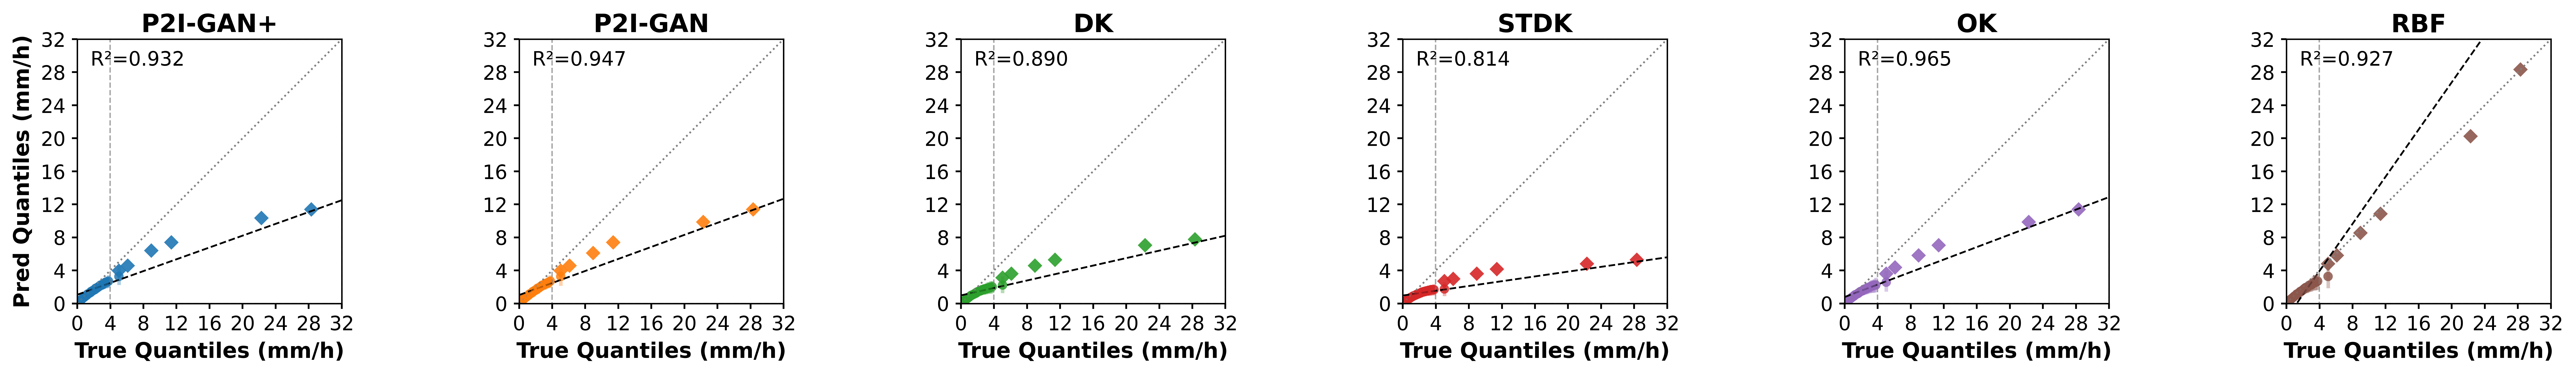

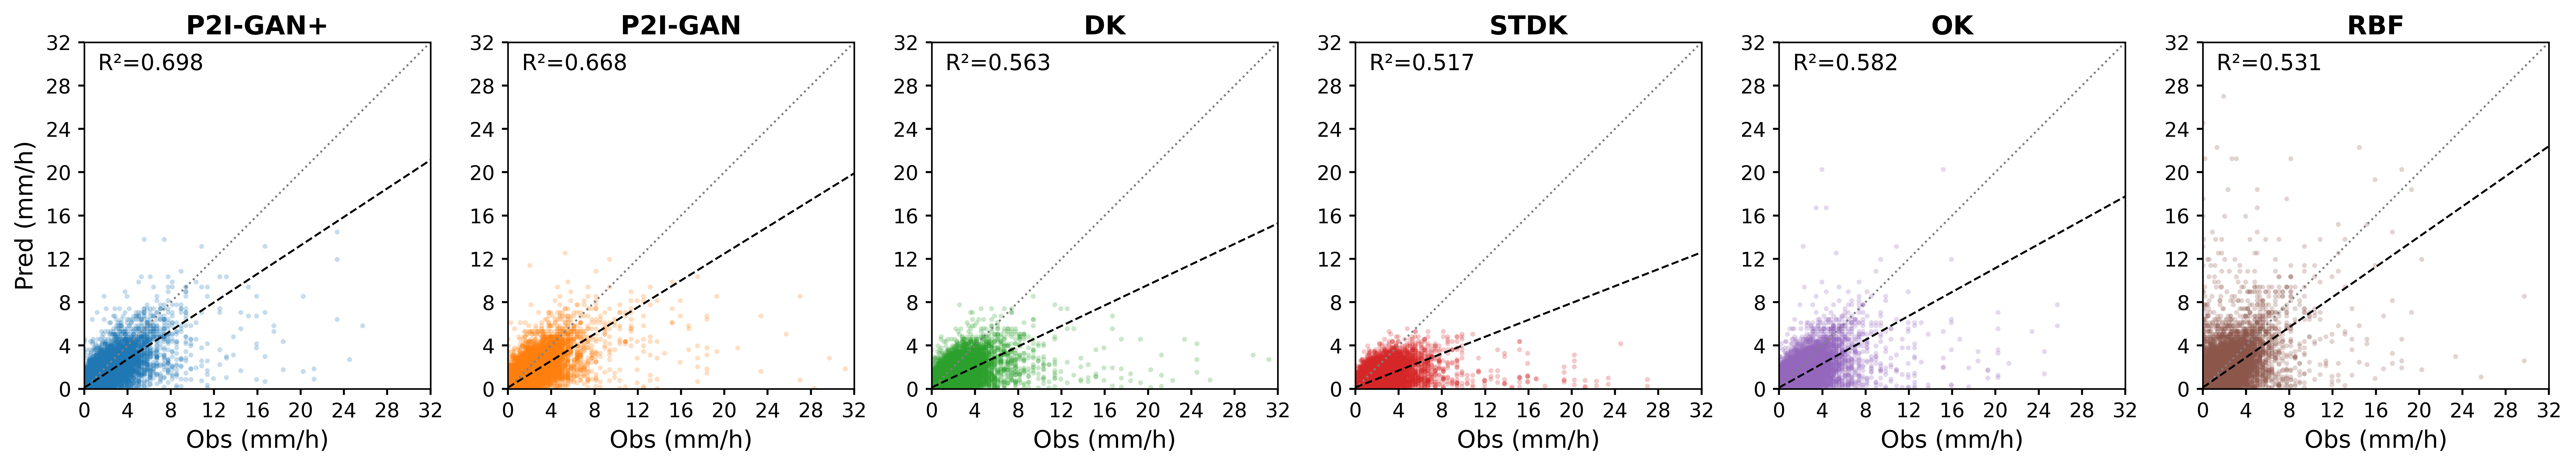

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import os
def transform(output):
    return 10 ** (output * 0.0625) * 0.036

def qqplot_multi_row(pred_list, true, labels, colors=None, figsize=(21, 3), dpi=600):
    """
    pred_list: list of np.ndarray，每組預測資料
    true: np.ndarray，真值
    labels: list of str，每組資料名稱
    colors: list of str，可選，顏色代碼
    """

    n = len(pred_list)
    if colors is None:
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c',
                  '#d62728', '#9467bd', '#8c564b']

    fig, axes = plt.subplots(1, n, figsize=figsize, dpi=dpi)
    # 代表點數
    NUM_PTS = 100
    quantiles = np.linspace(0, 1, NUM_PTS)

    true_flat = true.flatten()
    true_flat = true_flat[np.isfinite(true_flat)]          # 只保留有效值
    q_true = np.quantile(true_flat, quantiles)

    for i, (pred, label) in enumerate(zip(pred_list, labels)):
        ax = axes[i]

        pred_flat = pred.flatten()
        pred_flat = pred_flat[np.isfinite(pred_flat)]      # 只保留有效值
        q_pred = np.quantile(pred_flat, quantiles)

        # 以代表點擬合與繪圖
        slope, intercept, r, _, _ = stats.linregress(q_true, q_pred)

        ax.scatter(q_true, q_pred, s=32, alpha=0.6, color=colors[i], edgecolors='none')  # ← 代表點
        ax.plot(q_true, intercept + slope*q_true, 'k--', linewidth=1.0)
        ax.plot(q_true, q_true, 'gray', linestyle=':', linewidth=1.0)

        ax.set_title(label, fontsize=13, fontweight='bold', pad=4)
        ax.tick_params(axis='both', labelsize=10, width=1.0, length=3)
        ax.set_xticks([0, 4, 8, 12]); ax.set_yticks([0, 4, 8, 12])
        ax.set_xlim(0, 12); ax.set_ylim(0, 12)
        ax.set_aspect('equal', adjustable='box')
        ax.text(0.05, 0.9, f"R²={r**2:.3f}", transform=ax.transAxes, fontsize=11)
        ax.grid(False)


        # 僅第一張顯示 Y 標籤
        if i == 0:
            ax.set_ylabel("Pred Quantiles", fontsize=12)
        else:
            ax.set_ylabel(None)

        # 僅中間與最後幾張顯示 X 標籤
        ax.set_xlabel("True Quantiles", fontsize=12)

    plt.tight_layout(pad=1.0)
    plt.show()

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy import stats

QQ_COLORS = ['#1f77b4', '#ff7f0e', '#2ca02c',
             '#d62728', '#9467bd', '#8c564b']

def qqplot_multi_row_binned(pred_list, true, labels,
                            colors=QQ_COLORS, figsize=(18,3), dpi=300,
                            bulk_bins=30,      # 0~Q99 分成 30 箱：顯示散佈（以統計點）
                            tail_q=(0.99,0.995,0.997,0.999,0.9995,0.9999,0.99999, 0.99995),  # Q99 以上的強化分位
                            xticks=(0,4,8,12,16,20,24,28,32), yticks=(0,4,8,12,16,20,24,28,32),
                            lim=(0,12), point_size=28):

    n = len(pred_list)
    fig, axes = plt.subplots(1, n, figsize=figsize, dpi=dpi)

    true_flat = np.asarray(true, np.float64).ravel()
    true_flat = true_flat[np.isfinite(true_flat)]

    # —— 共同的 1:1 對角參考用 —— #
    x1 = np.linspace(lim[0], lim[1], 200)

    # —— 先算 bulk 的分箱邊界（0~Q99） —— #
    q99 = np.quantile(true_flat, 0.99)
    bulk_edges = np.linspace(true_flat.min(), q99, bulk_bins+1)

    for i, (pred, label) in enumerate(zip(pred_list, labels)):
        ax = axes[i]
        pf = np.asarray(pred, np.float64).ravel()
        mask = np.isfinite(pf)
        pf = pf[mask]; tf = true_flat[:pf.size]  # 對齊長度（保險）

        # 1) bulk：依 true 的值做分箱 → 每箱取 true/ pred 的中位數與 IQR
        inds = np.clip(np.digitize(tf, bulk_edges)-1, 0, bulk_bins-1)
        q_true_med, q_pred_med, q_pred_q25, q_pred_q75 = [], [], [], []
        for b in range(bulk_bins):
            sel = (inds == b)
            if sel.any():
                t_box = tf[sel]; p_box = pf[sel]
                q_true_med.append(np.median(t_box))
                q_pred_med.append(np.median(p_box))
                q_pred_q25.append(np.quantile(p_box, 0.25))
                q_pred_q75.append(np.quantile(p_box, 0.75))
        q_true_med = np.array(q_true_med); q_pred_med = np.array(q_pred_med)
        q_pred_q25 = np.array(q_pred_q25); q_pred_q75 = np.array(q_pred_q75)

        # 2) tails：Q99 以上用更密的分位點
        tail_q = np.array(tail_q)
        q_true_tail = np.quantile(tf, tail_q[tail_q > 0.99])
        q_pred_tail = np.quantile(pf, tail_q[tail_q > 0.99])

        # 3) 回歸線（用 bulk+tail 的代表點）
        x_fit = np.concatenate([q_true_med, q_true_tail])
        y_fit = np.concatenate([q_pred_med, q_pred_tail])
        slope, intercept, r, _, _ = stats.linregress(x_fit, y_fit)

        # —— 繪圖 —— #
        # (a) 1:1 線與回歸線
        ax.plot(x1, x1, color='gray', ls=':', lw=1.0)
        ax.plot(x1, intercept + slope*x1, 'k--', lw=1.0)

        # (b) bulk：中位點 + IQR（豎線）
        ax.vlines(q_true_med, q_pred_q25, q_pred_q75,
                  color=colors[i], alpha=0.35, lw=2)
        ax.scatter(q_true_med, q_pred_med, s=point_size,
                   color=colors[i], alpha=0.85, edgecolors='none')

        # (c) tails：用鑽石形標出
        ax.scatter(q_true_tail, q_pred_tail, s=point_size*1.2,
                   color=colors[i], marker='D', alpha=0.9, edgecolors='none')

        # 標題與座標系
        ax.set_title(label, fontsize=14, fontweight='bold', pad=4)
        ax.set_xlim(*lim); ax.set_ylim(*lim); ax.set_aspect('equal', 'box')
        ax.set_xticks(xticks); ax.set_yticks(yticks)
        ax.tick_params(axis='both', labelsize=11, width=1.0, length=3)
        ax.grid(False)
        ax.text(0.05, 0.90, f"R²={r**2:.3f}", transform=ax.transAxes, fontsize=11)

        # 提示：灰底框出 Q99 區域（可視化極端所在）
        ax.add_patch(Rectangle((q99, lim[0]), lim[1]-q99, lim[1]-lim[0],
                               fill=False, ec='gray', lw=0.8, ls='--', alpha=0.7))

        # 標籤：只保留 x 標籤；y 僅刻度不文字
        ax.set_xlabel("True Quantiles (mm/h)", fontsize=12, fontweight='bold')
        if i == 0:
            ax.set_ylabel("Pred Quantiles (mm/h)", fontsize=12, fontweight='bold')
        else:
            ax.set_ylabel(None)

    plt.tight_layout(pad=1.0)
    plt.savefig(f'qq.png', bbox_inches='tight')
    plt.show()

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

SCATTER_COLORS = ['#1f77b4', '#ff7f0e', '#2ca02c',
                  '#d62728', '#9467bd', '#8c564b']

def scatter_multi_row(pred_list, true, labels,
                      colors=SCATTER_COLORS,
                      figsize=(21, 3), dpi=600,
                      lim=(0, 12), xticks=(0,4,8,12,16,20,24,28,32), yticks=(0,4,8,12,16,20,24,28,32),
                      max_points=100000,  # 單圖最多散點（抽樣）
                      alpha=0.25, s=6,    # 透明度與點大小
                      seed=42, save_path=None):
    """
    pred_list : list[np.ndarray]  每組預測 (T,H,W) 或任意形狀
    true      : np.ndarray       真值，形狀與各預測可對齊
    labels    : list[str]        標題
    """

    rng = np.random.default_rng(seed)
    n = len(pred_list)
    fig, axes = plt.subplots(1, n, figsize=figsize, dpi=dpi)

    # 共同 1:1 線的 x
    x1 = np.linspace(lim[0], lim[1], 200)

    # 展平成 1D，僅保留有效值
    tf = np.asarray(true, np.float64).ravel()
    mask_t = np.isfinite(tf)
    tf = tf[mask_t]

    for i, (pred, label) in enumerate(zip(pred_list, labels)):
        ax = axes[i]
        pf = np.asarray(pred, np.float64).ravel()
        pf = pf[mask_t[:pf.size]] if pf.size <= mask_t.size else pf  # 基本對齊
        # 保留共同有限值
        m = np.isfinite(pf) & np.isfinite(tf[:pf.size])
        x = tf[:pf.size][m]
        y = pf[m]

        # 限制視窗範圍內的點以降低外圍極端影響
        in_box = (x >= lim[0]) & (x <= lim[1]) & (y >= lim[0]) & (y <= lim[1])
        x, y = x[in_box], y[in_box]

        # 抽樣
        if x.size > max_points:
            idx = rng.choice(x.size, size=max_points, replace=False)
            x, y = x[idx], y[idx]

        # 散點
        ax.scatter(x, y, s=s, alpha=alpha, color=colors[i],
           edgecolors='none', rasterized=True, zorder=1)

        # 回歸（以抽樣點）
        if x.size >= 2:
            slope, intercept, r, _, _ = stats.linregress(x, y)
            ax.plot(x1, x1, color='gray', ls=':', lw=1.0)                # 1:1
            ax.plot(x1, intercept + slope*x1, 'k--', lw=1.0)             # 回歸
            ax.text(0.04, 0.92, f"R²={r**2:.3f}", transform=ax.transAxes, fontsize=11)

        # 軸設定
        ax.set_title(label, fontsize=13, fontweight='bold', pad=4)
        ax.set_xlim(*lim); ax.set_ylim(*lim); ax.set_aspect('equal', 'box')
        ax.set_xticks(xticks); ax.set_yticks(yticks)
        ax.tick_params(axis='both', labelsize=10, width=1.0, length=3)
        ax.grid(False)

        if i == 0:
            ax.set_ylabel("Pred (mm/h)", fontsize=12)
        ax.set_xlabel("Obs (mm/h)", fontsize=12)

    plt.tight_layout(pad=1.0)
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()


def load_imgs(folder, event_range=range(20)):
    frames = []
    for event_id in event_range:
        folder_event = os.path.join(folder, f"rain{event_id}")
        files = sorted(
            [f for f in os.listdir(folder_event) if f.lower().endswith('.png')],
            key=lambda x: int(os.path.splitext(x)[0])
        )
        for fname in files:
            img = Image.open(os.path.join(folder_event, fname)).convert('L')
            w, h = img.size
            left = (w - 126) // 2; top = (h - 126) // 2
            right = left + 126; bottom = top + 126
            img = img.crop((left, top, right, bottom))
            arr = np.array(img).astype(np.float32) / 3.0
            arr = transform(arr)  # 你的轉換
            frames.append(arr)
    return np.stack(frames)   # [n_frames, H, W]

folders = {
    "Valid": r"C:\Users\n2000\Downloads\Evaluation\figs\interpolation_radar_event_val_20\a_radar_vaild",
    "P2I-GAN+": r"C:\Users\n2000\Downloads\Evaluation\figs\interpolation_radar_event_val_20\sti_basepos_val",
    "P2I-GAN":  r"C:\Users\n2000\Downloads\Evaluation\figs\interpolation_radar_event_val_20\sti_base_val",
    "DK":    r"C:\Users\n2000\Downloads\Evaluation\figs\interpolation_radar_event_val_20\sti_dk_val",
    "STDK":  r"C:\Users\n2000\Downloads\Evaluation\figs\interpolation_radar_event_val_20\sti_stdk_val",
    "OK":    r"C:\Users\n2000\Downloads\Evaluation\figs\interpolation_radar_event_val_20\c_ok",
    "RBF":   r"C:\Users\n2000\Downloads\Evaluation\figs\interpolation_radar_event_val_20\c_rbf",
}

# 讀檔
imgs = {name: load_imgs(path) for name, path in folders.items()}

# 對齊形狀（防止某些資料缺幀）：裁到共同最小幀數
min_T = min(arr.shape[0] for arr in imgs.values())
for k in imgs:
    imgs[k] = imgs[k][:min_T]

# 設定 true 與六組預測（照你 1×6 圖的順序）
true = imgs["Valid"]
pred_list = [
    imgs["P2I-GAN+"],
    imgs["P2I-GAN"],
    imgs["DK"],
    imgs["STDK"],
    imgs["OK"],
    imgs["RBF"],
]
labels = ["P2I-GAN+", "P2I-GAN", "DK", "STDK", "OK", "RBF"]

# 丟進你前面定義好的 qqplot_multi_row（會自動 flatten 做分位比較）
qqplot_multi_row_binned(pred_list, true, labels, figsize=(21,3), lim=(0,32), dpi=600)

scatter_multi_row(pred_list, true, labels, figsize=(18,3), dpi=600,
                  lim=(0,32), max_points=120000, alpha=0.25, s=6,
                  save_path="scatter_panels.pdf")



In [ ]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# ===== 可調參數 =====
Q = 0.75         # 分位數
THR = 0        # 門檻（與 transform() 後的量綱一致）
CROP_SIZE = 126   # 中央裁切尺寸
# ===================

def transform(output):
    # 你的特殊轉換
    return 10 ** (output * 0.0625) * 0.036


def valid_frame_mask(obs_stack, q=Q, thr=THR):
    """
    obs_stack: (T, H, W)
    回傳布林向量 keep: (T,)；當該幀 obs 的 q 分位數 >= thr 才保留
    """
    T = obs_stack.shape[0]
    flat = obs_stack.reshape(T, -1)
    # qv = np.quantile(flat, q, axis=1)
    qv = np.max(flat)
    keep = (qv >= thr)
    return keep

def calc_nse_filtered(sim_stack, obs_stack, input_stack, q=Q, thr=THR):
    """
    只在 keep 幀上計算 NSE；若無幀可用則回傳 np.nan
    sim_stack/obs_stack: (T, H, W)
    """
    assert sim_stack.shape == obs_stack.shape, "sim_stack 與 obs_stack 形狀需一致 (T,H,W)"
    keep = valid_frame_mask(input_stack, q=q, thr=thr)
    if not np.any(keep):
        return np.nan
    sim = sim_stack[keep].ravel()
    obs = obs_stack[keep].ravel()
    obs_mean = np.mean(obs)
    num = np.sum((obs - sim) ** 2)
    den = np.sum((obs - obs_mean) ** 2)
    if den == 0:
        return np.nan
    return 1 - num / den

def load_event_imgs(folder, event_id):
    """讀取指定 event 的所有影像並堆疊成 (T, H, W)"""
    event_folder = os.path.join(folder, f"rain{event_id}")
    files = sorted(
        [f for f in os.listdir(event_folder) if f.lower().endswith('.png')],
        key=lambda x: int(os.path.splitext(x)[0])
    )
    arrs = []
    for fname in files:
        img = Image.open(os.path.join(event_folder, fname)).convert('L')
        # 中央裁切 CROP_SIZE x CROP_SIZE
        w, h = img.size  # 預期 (128, 128)
        left = (w - CROP_SIZE) // 2
        top = (h - CROP_SIZE) // 2
        right = left + CROP_SIZE
        bottom = top + CROP_SIZE
        img = img.crop((left, top, right, bottom))
        arr = np.array(img).astype(np.float32) / 3.0
        arr = transform(arr)  # 若需 mm/hr 轉換請在 transform() 實作
        arrs.append(arr)
    if len(arrs) == 0:
        raise RuntimeError(f"找不到影像：{event_folder}")
    return np.stack(arrs, axis=0)  # (T, H, W)


folders = {
    "Input":   r"C:\Users\n2000\Downloads\Evaluation\figs\interpolation_radar_event_val_20\a_radar_input",
    "Valid": r"C:\Users\n2000\Downloads\Evaluation\figs\interpolation_radar_event_val_20\a_radar_vaild",
    "P2I-GAN+": r"C:\Users\n2000\Downloads\Evaluation\figs\interpolation_radar_event_val_20\sti_basepos_val",
    "P2I-GAN":  r"C:\Users\n2000\Downloads\Evaluation\figs\interpolation_radar_event_val_20\sti_base_val",
    "DK":    r"C:\Users\n2000\Downloads\Evaluation\figs\interpolation_radar_event_val_20\sti_dk_val",
    "STDK":  r"C:\Users\n2000\Downloads\Evaluation\figs\interpolation_radar_event_val_20\sti_stdk_val",
    "OK":    r"C:\Users\n2000\Downloads\Evaluation\figs\interpolation_radar_event_val_20\c_ok",
    "RBF":   r"C:\Users\n2000\Downloads\Evaluation\figs\interpolation_radar_event_val_20\c_rbf",
}

method_names = [k for k in folders if k != "Valid" and k != "Input"]
event_ids = range(20)

results = {m: [] for m in method_names}

for event_id in event_ids:
    valid_stack = load_event_imgs(folders["Valid"], event_id)  # (T,H,W)
    input_stack = load_event_imgs(folders["Input"], event_id)  # (T,H,W)
    for method in method_names:
        pred_stack = load_event_imgs(folders[method], event_id)  # (T,H,W)
        # 保證 shape 一樣
        assert pred_stack.shape == valid_stack.shape, f"形狀不一致：{method}, event {event_id}"
        # 只在通過門檻的幀上計算 NSE（不再 flatten）
        nse = calc_nse_filtered(pred_stack, valid_stack, input_stack, q=Q, thr=THR)
        results[method].append(nse)

# --- 繪圖風格調整版 ---
plt.figure(figsize=(6, 4))
box = plt.boxplot(
    [results[m] for m in method_names],
    labels=method_names,
    patch_artist=True,   # 填色
    showmeans=True,
    meanline=False,
    boxprops=dict(linewidth=1.2, color='black'),
    medianprops=dict(linewidth=2.0, color='black'),
    whiskerprops=dict(linewidth=1.2, color='black'),
    capprops=dict(linewidth=1.2, color='black'),
    flierprops=dict(marker='o', markersize=3, alpha=0.5, color='gray'),
    meanprops=dict(marker='D', markerfacecolor='white', markeredgecolor='black', markersize=5)
)

# 給每個 box 填顏色（類似 hydrology 常見的風格）

colors = ['#1f77b4', '#ff7f0e', '#2ca02c',
             '#d62728', '#9467bd', '#8c564b']

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

plt.ylabel('NSE', fontsize=14)
plt.xlabel('Methods', fontsize=13)
plt.title(f'NSE Comparison ({len(event_ids)} Rain Events)', fontsize=14, fontweight='bold')
plt.ylim(-0.2, 1.0)

plt.grid(False)
plt.tick_params(axis='both', labelsize=11)
plt.tight_layout()
plt.savefig('nse_boxplot_refined.pdf', format='pdf', bbox_inches='tight')
plt.show()



In [ ]:
# -*- coding: utf-8 -*-
import os
import numpy as np
from PIL import Image
import matplotlib as mpl
import matplotlib.pyplot as plt

# ====== Plot style (IEEE-like) ======
mpl.rcParams.update({
    "font.size": 9,
    "axes.titlesize": 10,
    "axes.labelsize": 9,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "legend.fontsize": 8,
    "axes.linewidth": 0.9,
    "grid.linewidth": 0.6,
    "lines.linewidth": 1.2,
    "pdf.fonttype": 42,  # editable text in Illustrator
    "ps.fonttype": 42,
})

# ===== 參數 =====
CROP_SIZE = 128
COUNT_THR = 0.5                # Input 門檻 (mm/h) 用於可見比例
BIN_EDGES = np.array([0, 5, 15, 30, 50, 100], dtype=float)  # % bins
BIN_LABELS = ["0–5%", "5–15%", "15–30%", "30–50%", "50–100%"]
MIN_SAMPLES_PER_BIN = 5
COLOR_BASE   = "#1f77b4"
COLOR_BASE_P = "#ff7f0e"

Q_FILTER  = 0.75   # frame 過濾的分位數
THR_FILTER = 0.0   # frame 過濾門檻（在 transform 後量綱）

def transform(output):
    return 10 ** (output * 0.0625) * 0.036

def load_event_imgs(folder, event_id):
    event_folder = os.path.join(folder, f"rain{event_id}")
    files = sorted([f for f in os.listdir(event_folder) if f.lower().endswith('.png')],
                   key=lambda x: int(os.path.splitext(x)[0]))
    arrs = []
    for fname in files:
        img = Image.open(os.path.join(event_folder, fname)).convert('L')
        w, h = img.size
        l = (w - CROP_SIZE)//2; t = (h - CROP_SIZE)//2
        img = img.crop((l, t, l+CROP_SIZE, t+CROP_SIZE))
        arr = np.array(img, np.float32)/3.0
        arr = transform(arr)
        arrs.append(arr)
    if not arrs:
        raise RuntimeError(f"找不到影像：{event_folder}")
    return np.stack(arrs, axis=0)  # (T,H,W)

def valid_frame_mask(stack, q=Q_FILTER, thr=THR_FILTER):
    """逐幀：分位數 >= thr 視為有效。"""
    T = stack.shape[0]
    flat = stack.reshape(T, -1)
    qv = np.quantile(flat, q, axis=1)
    return (qv >= thr)

def nse_per_frame_filtered(sim_stack, obs_stack, ref_stack, q=Q_FILTER, thr=THR_FILTER):
    """僅在 keep 幀計算 NSE；其他回傳 NaN。"""
    assert sim_stack.shape == obs_stack.shape
    keep = valid_frame_mask(ref_stack, q=q, thr=thr)  # (T,)
    T = sim_stack.shape[0]
    out = np.full(T, np.nan, dtype=np.float64)
    for t in range(T):
        if not keep[t]:
            continue
        sim = sim_stack[t].ravel()
        obs = obs_stack[t].ravel()
        mu  = obs.mean()
        den = np.sum((obs - mu)**2)
        if den == 0:
            out[t] = np.nan
        else:
            num = np.sum((obs - sim)**2)
            out[t] = 1.0 - num/den
    return out

# ===== 路徑 =====
folders = {
    "Input":  r"C:\Users\n2000\Downloads\Evaluation\figs\interpolation_radar_event_val_20\a_radar_input",
    "Valid":  r"C:\Users\n2000\Downloads\Evaluation\figs\interpolation_radar_event_val_20\a_radar_vaild",
    "Base+":  r"C:\Users\n2000\Downloads\Evaluation\figs\interpolation_radar_event_val_20\sti_baseplus_val",
    "Base":   r"C:\Users\n2000\Downloads\Evaluation\figs\interpolation_radar_event_val_20\sti_base_val",
}
event_ids = range(20)

# ===== 讀取測站遮罩（只用於可見比例）=====
mask_path = r"C:\Users\n2000\Downloads\Evaluation\rain_gauge_mask_128_train.txt"
mask = np.loadtxt(mask_path).astype(np.uint8)
if mask.shape != (CROP_SIZE, CROP_SIZE):
    raise ValueError(f"mask shape {mask.shape} != ({CROP_SIZE},{CROP_SIZE})")
mask_bool  = (mask == 1)
flat_mask  = mask_bool.ravel()
n_mask_pts = int(flat_mask.sum())
if n_mask_pts == 0:
    raise ValueError("mask 內沒有任何 1。")

# ===== 蒐集逐幀資料（‼️ 這裡使用『過濾版 NSE』）=====
vis_all, nse_b_all, nse_bp_all = [], [], []

for eid in event_ids:
    valid = load_event_imgs(folders["Valid"],  eid)
    inputv = load_event_imgs(folders["Input"],  eid)
    basep  = load_event_imgs(folders["Base+"],  eid)
    base   = load_event_imgs(folders["Base"],   eid)

    # 對齊 T
    T = min(valid.shape[0], inputv.shape[0], base.shape[0], basep.shape[0])
    valid, inputv, base, basep = valid[:T], inputv[:T], base[:T], basep[:T]

    # 逐幀可見比例（僅在測站位置）
    inp_flat = inputv.reshape(T, -1)[:, flat_mask]      # [T, n_mask_pts]
    active   = (inp_flat > COUNT_THR).sum(axis=1).astype(float)  # [T]
    vis_pct  = (active / n_mask_pts) * 100.0
    vis_all.append(vis_pct)

    # 逐幀 NSE（過濾版）
    nse_b  = nse_per_frame_filtered(base,  valid, inputv)
    nse_bp = nse_per_frame_filtered(basep, valid, inputv)
    nse_b_all.append(nse_b)
    nse_bp_all.append(nse_bp)

# 串接
vis_all   = np.concatenate(vis_all)
nse_b_all = np.concatenate(nse_b_all)
nse_bp_all= np.concatenate(nse_bp_all)

# 僅保留有效樣本
ok = np.isfinite(vis_all) & np.isfinite(nse_b_all) & np.isfinite(nse_bp_all)
vis_all, nse_b_all, nse_bp_all = vis_all[ok], nse_b_all[ok], nse_bp_all[ok]

# ===== 分箱（0–100%）=====
edges = BIN_EDGES.copy()
edges[-1] += 1e-6  # include 100%
bin_idx = np.digitize(vis_all, edges, right=False) - 1  # 0..len-2

def median_iqr(y, idx, k):
    v = y[idx == k]
    if v.size < MIN_SAMPLES_PER_BIN:
        return np.nan, np.nan, np.nan
    q1 = np.nanpercentile(v, 25)
    md = np.nanmedian(v)
    q3 = np.nanpercentile(v, 75)
    return md, q1, q3

stats_b  = np.array([median_iqr(nse_b_all,  bin_idx, k) for k in range(len(BIN_LABELS))])
stats_bp = np.array([median_iqr(nse_bp_all, bin_idx, k) for k in range(len(BIN_LABELS))])

md_b, q1_b, q3_b   = stats_b[:,0],  stats_b[:,1],  stats_b[:,2]
md_bp, q1_bp, q3_bp= stats_bp[:,0], stats_bp[:,1], stats_bp[:,2]
yerr_b  = np.vstack([md_b  - q1_b,  q3_b  - md_b ])
yerr_bp = np.vstack([md_bp - q1_bp, q3_bp - md_bp])

# ===== 繪圖（IEEE 風格）=====
fig, ax = plt.subplots(figsize=(3.6, 2.6), dpi=300)

x = np.arange(len(BIN_LABELS))
dx = 0.18

ax.errorbar(x - dx, md_b,  yerr=yerr_b,  fmt='o', capsize=3, elinewidth=0.9,
            color=COLOR_BASE,  mfc=COLOR_BASE,  mec=COLOR_BASE,  alpha=0.9, label='Base')
ax.errorbar(x + dx, md_bp, yerr=yerr_bp, fmt='o', capsize=3, elinewidth=0.9,
            color=COLOR_BASE_P, mfc=COLOR_BASE_P, mec=COLOR_BASE_P, alpha=0.9, label='Base+')

# 半透明 IQR 背景帶（可選）
for i in range(len(BIN_LABELS)):
    if np.isfinite(q1_b[i]) and np.isfinite(q3_b[i]):
        ax.fill_between([i - 0.38, i - 0.02], q1_b[i], q3_b[i], color=COLOR_BASE,  alpha=0.15, linewidth=0)
    if np.isfinite(q1_bp[i]) and np.isfinite(q3_bp[i]):
        ax.fill_between([i + 0.02, i + 0.38], q1_bp[i], q3_bp[i], color=COLOR_BASE_P, alpha=0.15, linewidth=0)

ax.axhline(0.0, color='0.6', ls='--', lw=0.9)
ax.set_xticks(x); ax.set_xticklabels(BIN_LABELS)
ax.set_xlim(-0.6, len(BIN_LABELS)-0.4)
ax.set_ylim(0.0, 1.0)                      # 你的要求：固定 0–1
ax.set_xlabel(f"Visibility at gauges (%)  (Input > {COUNT_THR} mm/h)")
ax.set_ylabel("NSE")
ax.legend(frameon=False, loc='lower right')
ax.grid(False)

plt.tight_layout()
plt.savefig("nse_visibility_bins_ieee.pdf", bbox_inches="tight")
plt.savefig("nse_visibility_bins_ieee.png", dpi=600, bbox_inches="tight")
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm

thresholds = [0.1, 0.5, 2.0, 8.0, 16.0]
colors = [
    (0, 0, 0.8),    # 深藍
    (0, 1, 0),      # 綠
    (1, 1, 0),      # 黃
    (1, 0.5, 0),    # 橘
    (1, 0, 0)       # 紅
]

# 步驟：將 thresholds 映射到 0~1 範圍
import numpy as np
bounds = np.array(thresholds)
norm_vals = (np.log10(bounds) - np.log10(bounds[0])) / (np.log10(bounds[-1]) - np.log10(bounds[0]))

cmap = LinearSegmentedColormap.from_list("my_radar", list(zip(norm_vals, colors)), N=256)

# BoundaryNorm: 讓你只在顏色映射上"正確分級"而不強制分級（仍然是連續色帶）
norm = BoundaryNorm(bounds, cmap.N)


C:\Users\n2000\AppData\Local\Temp\ipykernel_185540\1292693801.py:211: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.7])


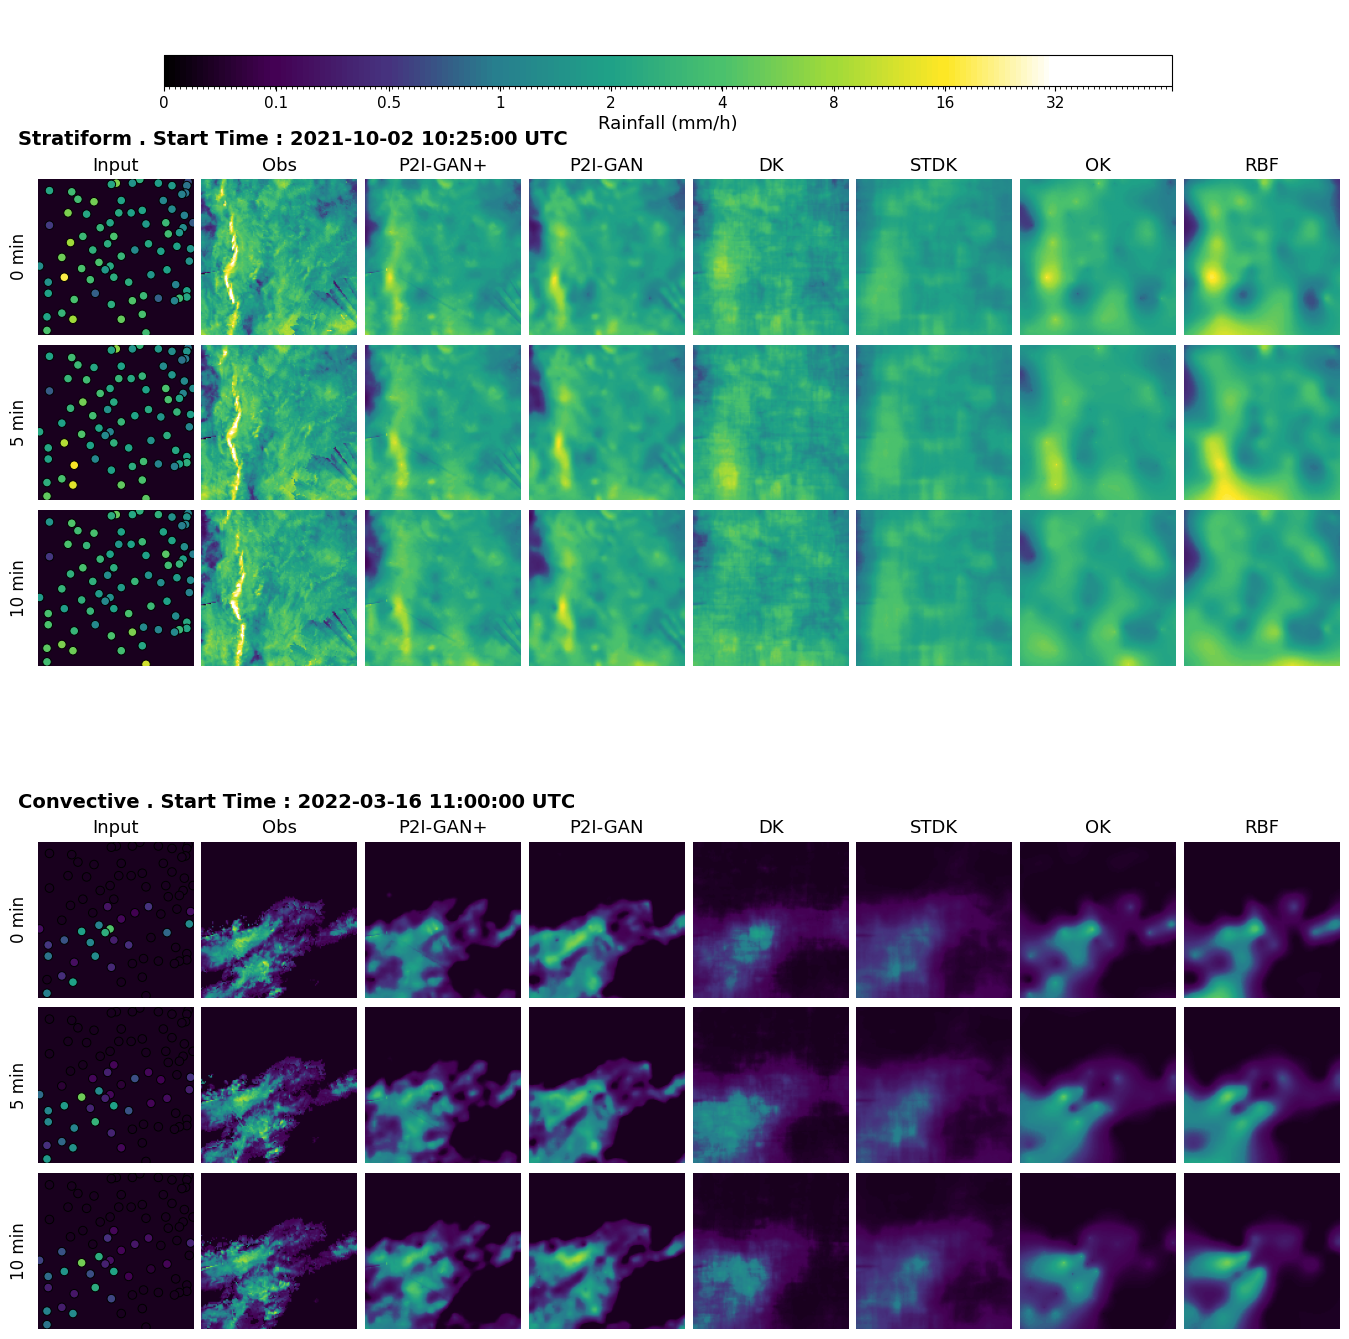

In [5]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


def transform(output):
    return 10 ** (output * 0.0625) * 0.036  # mm/hr 轉換



# ==== 1) 自訂分段 + 平滑色帶（用在所有子圖）====
from matplotlib.colors import ListedColormap, BoundaryNorm

# 主分級（mm/hr）
bounds = [0, 0.1, 0.5, 1, 2, 4, 8, 16, 32, 200]  # 9 段
# colors_log = [
#     "#434a87", "#0000ff", "#00a5c5", "#afd081",
#     "#ffed11", "#f1882c", "#ff0000", "#e72582", "#fffefd"
# ]
colors_log = [
    "#000000",  # 黑色（最低值或背景）
    "#440154",  # 深紫
    "#46327e",  # 靛紫
    "#277f8e",  # 藍綠
    "#1fa187",  # 青綠
    "#4ac16d",  # 草綠
    "#a0da39",  # 黃綠
    "#fde725",  # 黃色
    "#ffffff"   # 白色（最高值或飽和）
]

SUB = 20  # 每段之間做 20 個子區間的線性過渡

def hex_to_rgb01(h):
    h = h.lstrip("#")
    return tuple(int(h[i:i+2], 16)/255.0 for i in (0,2,4))

def lerp(a, b, t):
    return tuple((1-t)*ai + t*bi for ai, bi in zip(a, b))

# 細分邊界
fine_bounds = []
for i in range(len(bounds)-1):
    seg = np.linspace(bounds[i], bounds[i+1], SUB+1, endpoint=False)
    if i == 0: fine_bounds.extend(seg.tolist())
    else:      fine_bounds.extend(seg[1:].tolist())
fine_bounds.append(bounds[-1])
fine_bounds = np.asarray(fine_bounds, float)

# 平滑過渡顏色
rgb_base = [hex_to_rgb01(h) for h in colors_log]
grad_colors = []
for i in range(len(rgb_base)-1):
    c0, c1 = rgb_base[i], rgb_base[i+1]
    for k in range(SUB):
        t = k / float(SUB-1)
        grad_colors.append(lerp(c0, c1, t))
grad_colors.append(rgb_base[-1])  # 最終色
while len(grad_colors) < len(fine_bounds) - 1:
    grad_colors.append(rgb_base[-1])

cmap = ListedColormap(grad_colors, name=f"seg{SUB}_smooth")
norm = BoundaryNorm(fine_bounds, cmap.N, clip=True)

# 讀 mask
mask_path = r"C:\Users\n2000\Downloads\Evaluation\rain_gauge_mask_128_train.txt"
mask = np.loadtxt(mask_path)
# 裁中間 123×123
H, W = mask.shape
ch, cw = 126, 126
sh, sw = (H - ch) // 2, (W - cw) // 2
mask = mask[sh:sh+ch, sw:sw+cw]


mask_points = np.argwhere(mask == 1)  # y, x 座標（row, col）

# 指定資料夾

ffolders = {
    "Obs":   r"C:\Users\n2000\Downloads\Evaluation\figs\interpolation_radar_event_val_20\a_radar_vaild",
    "Input":   r"C:\Users\n2000\Downloads\Evaluation\figs\interpolation_radar_event_val_20\a_radar_input",
    "P2I-GAN+":      r"C:\Users\n2000\Downloads\Evaluation\figs\interpolation_radar_event_val_20\sti_basepos_val",
    "P2I-GAN":    r"C:\Users\n2000\Downloads\Evaluation\figs\interpolation_radar_event_val_20\sti_base_val",
    "DK":        r"C:\Users\n2000\Downloads\Evaluation\figs\interpolation_radar_event_val_20\sti_dk_val",
    "STDK":     r"C:\Users\n2000\Downloads\Evaluation\figs\interpolation_radar_event_val_20\sti_stdk_val",
    "OK":      r"C:\Users\n2000\Downloads\Evaluation\figs\interpolation_radar_event_val_20\c_ok",
    "RBF":     r"C:\Users\n2000\Downloads\Evaluation\figs\interpolation_radar_event_val_20\c_rbf"
}


# ====== 統一 colorbar + 兩事件上下排列 + 各自粗框標題（單張圖, 輸出 PDF） ======
import os, numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

method_order = ["Input", "Obs", "P2I-GAN+", "P2I-GAN", "DK", "STDK", "OK", "RBF"]

# === 假設你已有 cmap, norm, mask, mask_points, transform, ffolders, method_order 等 ===

events = [
    {"event_id": 8,  "select_idx": [65, 66, 67],
     "title": "Stratiform . Start Time : 2021-10-02 10:25:00 UTC"},
    {"event_id": 12, "select_idx": [0, 1, 2],
     "title": "Convective . Start Time : 2022-03-16 11:00:00 UTC"},
]

def load_event_images(event_id, select_idx):
    rain_str = f"rain{event_id}"
    sample_folder = os.path.join(ffolders["Obs"], rain_str)
    all_pngs = sorted([f for f in os.listdir(sample_folder) if f.lower().endswith('.png')],
                      key=lambda x: int(os.path.splitext(x)[0]))
    imgs = []
    for method in method_order:
        folder = os.path.join(ffolders[method], rain_str)
        frames = []
        for idx in select_idx:
            path = os.path.join(folder, all_pngs[idx])
            arr = np.array(Image.open(path).convert('F')).astype(np.float32) / 3.0
            arr = transform(arr)
            H, W = arr.shape
            ch, cw = 126, 126
            sh, sw = (H - ch)//2, (W - cw)//2
            frames.append(arr[sh:sh+ch, sw:sw+cw])
        imgs.append(frames)
    return np.array(imgs)

def draw_block(ax_grid, images, select_idx, minutes_per_step=5, use_select_as_minutes=False):
    n_method = len(method_order)
    n_time   = len(select_idx)
    last_im = None
    for t in range(n_time):
        for m in range(n_method):
            ax = ax_grid[t, m]
            last_im = ax.imshow(images[m, t], cmap=cmap, norm=norm)

            # 不要用 ax.axis('off')，改成只隱藏刻度與邊框
            ax.set_xticks([]); ax.set_yticks([])
            for s in ax.spines.values():
                s.set_visible(False)

            if method_order[m] == "Input":
                vals = images[m, t][mask == 1]
                ax.scatter(mask_points[:,1], mask_points[:,0],
                           c=vals, cmap=cmap, norm=norm,
                           s=38, edgecolors='black', linewidths=0.7, zorder=5)

            if t == 0:
                ax.set_title(method_order[m], fontsize=13)

            # 左側加時間標籤（畫在軸座標外側，確保不會被隱藏）
            if m == 0:
                if use_select_as_minutes:
                    time_label = f"{select_idx[t]} min"
                else:
                    time_label = f"{t*minutes_per_step} min"
                ax.text(-0.12, 0.5, time_label, transform=ax.transAxes,
                    ha='center', va='center', fontsize=12, rotation=90)


    return last_im


# === 設定畫布 ===
ncols = len(method_order)
nrows_each = len(events[0]["select_idx"])

# 每個事件：1 列標題 + 多列圖片
total_rows = (nrows_each + 1) * len(events)

fig = plt.figure(figsize=(2.1*ncols, 1.9*total_rows))
gs  = GridSpec(nrows=total_rows, ncols=ncols, figure=fig,
               top=0.93, bottom=0.06, wspace=0.05, hspace=0.02)

# === colorbar ===
from matplotlib.cm import ScalarMappable
sm = ScalarMappable(cmap=cmap, norm=norm); sm.set_array([])
cbar_ax = fig.add_axes([0.20, 0.88, 0.60, 0.02])
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal', ticks=bounds)
tick_labels = [f"{b:g}" for b in bounds[:-1]] + [""]
cbar.set_ticklabels(tick_labels)
cbar.set_label("Rainfall (mm/h)", fontsize=13, labelpad=3)
cbar.ax.tick_params(labelsize=11)

# === 畫每個事件 ===
row_cursor = 0
for e in events:
    # 標題列
    ax_title = fig.add_subplot(gs[row_cursor, :])
    ax_title.axis("off")
    ax_title.text(-0.015, 0.2, e["title"],
              fontsize=14, fontweight="bold", ha="left", va="center",
              transform=ax_title.transAxes)

    row_cursor += 1

   # 圖片列
    ax_grid = np.empty((nrows_each, ncols), dtype=object)
    for r in range(nrows_each):
        for c in range(ncols):
            ax_grid[r, c] = fig.add_subplot(gs[row_cursor + r, c])

    # 繪製圖像
    imgs = load_event_images(e["event_id"], e["select_idx"])
    _ = draw_block(ax_grid, imgs, e["select_idx"])

    row_cursor += nrows_each


plt.tight_layout(rect=[0, 0, 1, 0.7])
fig.savefig("two_events_stacked_titles.pdf", format="pdf", bbox_inches="tight")
# plt.close(fig)


In [6]:
# --- Crop two regions from a PDF page, stitch, visualize, and save (PNG/PDF) ---
# pip install pymupdf pillow

import fitz  # PyMuPDF
from PIL import Image

def crop_regions_from_pdf(pdf_path, page_index, rects_pts, zoom=2.0):
    """
    pdf_path  : path to PDF
    page_index: 0-based page index
    rects_pts : list[(x0,y0,x1,y1)] in PDF points (1pt = 1/72 inch)
    zoom      : render scale (2.0 ≈ 144 DPI, 3.0 ≈ 216 DPI)
    return    : list[PIL.Image]
    """
    doc = fitz.open(pdf_path)
    page = doc[page_index]
    images = []
    mat = fitz.Matrix(zoom, zoom)
    for (x0, y0, x1, y1) in rects_pts:
        clip = fitz.Rect(x0, y0, x1, y1)
        pix = page.get_pixmap(matrix=mat, clip=clip, alpha=False)
        images.append(Image.frombytes("RGB", [pix.width, pix.height], pix.samples))
    doc.close()
    return images

def crop_regions_from_pdf_rel(pdf_path, page_index, rects_rel, zoom=2.0):
    """
    rects_rel: list of rectangles in relative fractions: (x0,y0,x1,y1) in [0,1]
               relative to the page box (media box).
    """
    doc = fitz.open(pdf_path)
    page = doc[page_index]
    (X0, Y0, X1, Y1) = page.rect  # in points
    rects_pts = []
    for (rx0, ry0, rx1, ry1) in rects_rel:
        rects_pts.append((X0 + rx0*(X1-X0), Y0 + ry0*(Y1-Y0),
                          X0 + rx1*(X1-X0), Y0 + ry1*(Y1-Y0)))
    doc.close()
    return crop_regions_from_pdf(pdf_path, page_index, rects_pts, zoom=zoom)

def stitch_images(imgs, direction="h", gap=0, bg=(255,255,255)):
    """
    direction: "h" horizontal, "v" vertical
    gap      : pixels between parts
    """
    if direction == "h":
        H = max(im.height for im in imgs)
        W = sum(im.width for im in imgs) + gap*(len(imgs)-1)
        canvas = Image.new("RGB", (W, H), bg)
        x = 0
        for im in imgs:
            y = (H - im.height)//2
            canvas.paste(im, (x, y))
            x += im.width + gap
    else:
        W = max(im.width for im in imgs)
        H = sum(im.height for im in imgs) + gap*(len(imgs)-1)
        canvas = Image.new("RGB", (W, H), bg)
        y = 0
        for im in imgs:
            x = (W - im.width)//2
            canvas.paste(im, (x, y))
            y += im.height + gap
    return canvas


# —— 直接指定「上半 + 下半」；可設邊界與中間間隙 ——
# 依舊使用前面定義的 crop_regions_from_pdf_rel(), stitch_images()

def crop_by_y_ranges(pdf_path, page_index=0, zoom=1.0,
                     y_ranges=((0.019, 0.5), (0.58, 1.0)),   # 依序裁哪些 y 區段（相對比例 0~1）
                     margin_left=0.00, margin_right=0.00):  # 左右邊界（相對比例）
    rects_rel = []
    for (y0, y1) in y_ranges:
        y0c = max(0.0, min(1.0, y0))
        y1c = max(0.0, min(1.0, y1))
        if y1c <= y0c: 
            continue
        rects_rel.append((margin_left, y0c, 1 - margin_right, y1c))
    return crop_regions_from_pdf_rel(pdf_path, page_index, rects_rel, zoom=zoom)


# ==== Example usage ====
pdf_path = "two_events_stacked_titles.pdf"

parts = crop_by_y_ranges(
    pdf_path, page_index=0, zoom=3.0,
)

stitched = stitch_images(parts, direction="v", gap=8, bg=(255,255,255))

# Preview (optional)
stitched.show()

# Save
stitched.save("cropped_stitched.pdf")  # vector container with raster content


In [ ]:
import os
import numpy as np
from PIL import Image

def transform(output):
    # 你的特殊轉換
    return 10 ** (output * 0.0625) * 0.036

def load_imgs(folder, event_range=range(10)):
    frames = []
    for event_id in event_range:
        folder_event = os.path.join(folder, f"rain{event_id}")
        files = sorted([f for f in os.listdir(folder_event) if f.lower().endswith('.png')],
                       key=lambda x: int(os.path.splitext(x)[0]))
        for fname in files:
            img = Image.open(os.path.join(folder_event, fname)).convert('L')
            arr = np.array(img).astype(np.float32) / 3.0
            arr = transform(arr)
            frames.append(arr)
    return np.stack(frames)   # [n_frames, H, W]

# 讀取mask（假設是純 0/1 txt 檔，shape [H,W]）
def load_mask(mask_path):
    # 若 mask 檔案是 txt, 可用 numpy 直接讀
    mask = np.loadtxt(mask_path)
    # 若你 mask 檔案本身是 bool/int 格式，無需再處理
    return mask.astype(bool)

# 加上 mask 之後的評估指標
def mae(pred, gt, mask):
    return np.mean(np.abs(pred[mask] - gt[mask]))

def rmse(pred, gt, mask):
    return np.sqrt(np.mean((pred[mask] - gt[mask]) ** 2))

def tgd(pred, gt, mask_3d):
    delta_pred = np.diff(pred, axis=0)
    delta_gt = np.diff(gt, axis=0)
    mask_diff = mask_3d[1:]  # diff 後 frames 少 1
    return np.mean(np.abs(delta_pred[mask_diff] - delta_gt[mask_diff]))

def cprs(pred, gt, mask_3d):
    pred_flat = pred[mask_3d].flatten()
    gt_flat = gt[mask_3d].flatten()
    return np.corrcoef(pred_flat, gt_flat)[0, 1]

# ==== 路徑設定 ====
base_dir = r"C:\Users\n2000\Downloads\Evaluation\figs\merge_radar_gauge_val_10"
folders = {
    "Gauge_Input":  f"{base_dir}\\a_gauge_input",
    "Gauge_Valid":  f"{base_dir}\\a_gauge_vaild",
    "Radar_Input":  f"{base_dir}\\a_radar_input",
    "P2I-GAN+":    f"{base_dir}\\merge_basepos_val",
    "P2I-GAN":   f"{base_dir}\\merge_base_val",
    "DK":    f"{base_dir}\\merge_dk_val",
    "STDK":    f"{base_dir}\\merge_stdk_val",
    "C_KED":        f"{base_dir}\\c_ked",
    "C_KRE":        f"{base_dir}\\c_kre"
}

folder_B = folders["Gauge_Valid"]  # 真值
mask_path = r"C:\Users\n2000\Downloads\Evaluation\rain_gauge_mask_128_val.txt"

# 讀 mask
mask = load_mask(mask_path)
mask = np.broadcast_to(mask, (1, mask.shape[0], mask.shape[1]))  # 先成 3D
print(f"Mask loaded, total valid pixels: {mask.sum()}")

for name, folder_A in folders.items():
    if name == "Gauge_Valid":
        continue  # 跳過真值自己比對自己

    # 1. 讀入所有影像
    A = load_imgs(folder_A)
    B = load_imgs(folder_B)
    assert A.shape == B.shape, f"{name} 數量或 shape 不一致！"

    # 讓 mask broadcast 到影像 shape
    mask_b = np.broadcast_to(mask, A.shape)

    # 2. 算分數（只用 mask=1 處的像素）
    mae_score = mae(A, B, mask_b)
    rmse_score = rmse(A, B, mask_b)
    cprs_score = cprs(A, B, mask_b)

    print(f"[{name}]")
    print(f"MAE:   {mae_score:.4f}")
    print(f"RMSE:  {rmse_score:.4f}")
    print(f"CPRS:  {cprs_score:.4f}")
    print("-" * 30)


C:\Users\n2000\AppData\Local\Temp\ipykernel_43800\218521411.py:211: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.7])


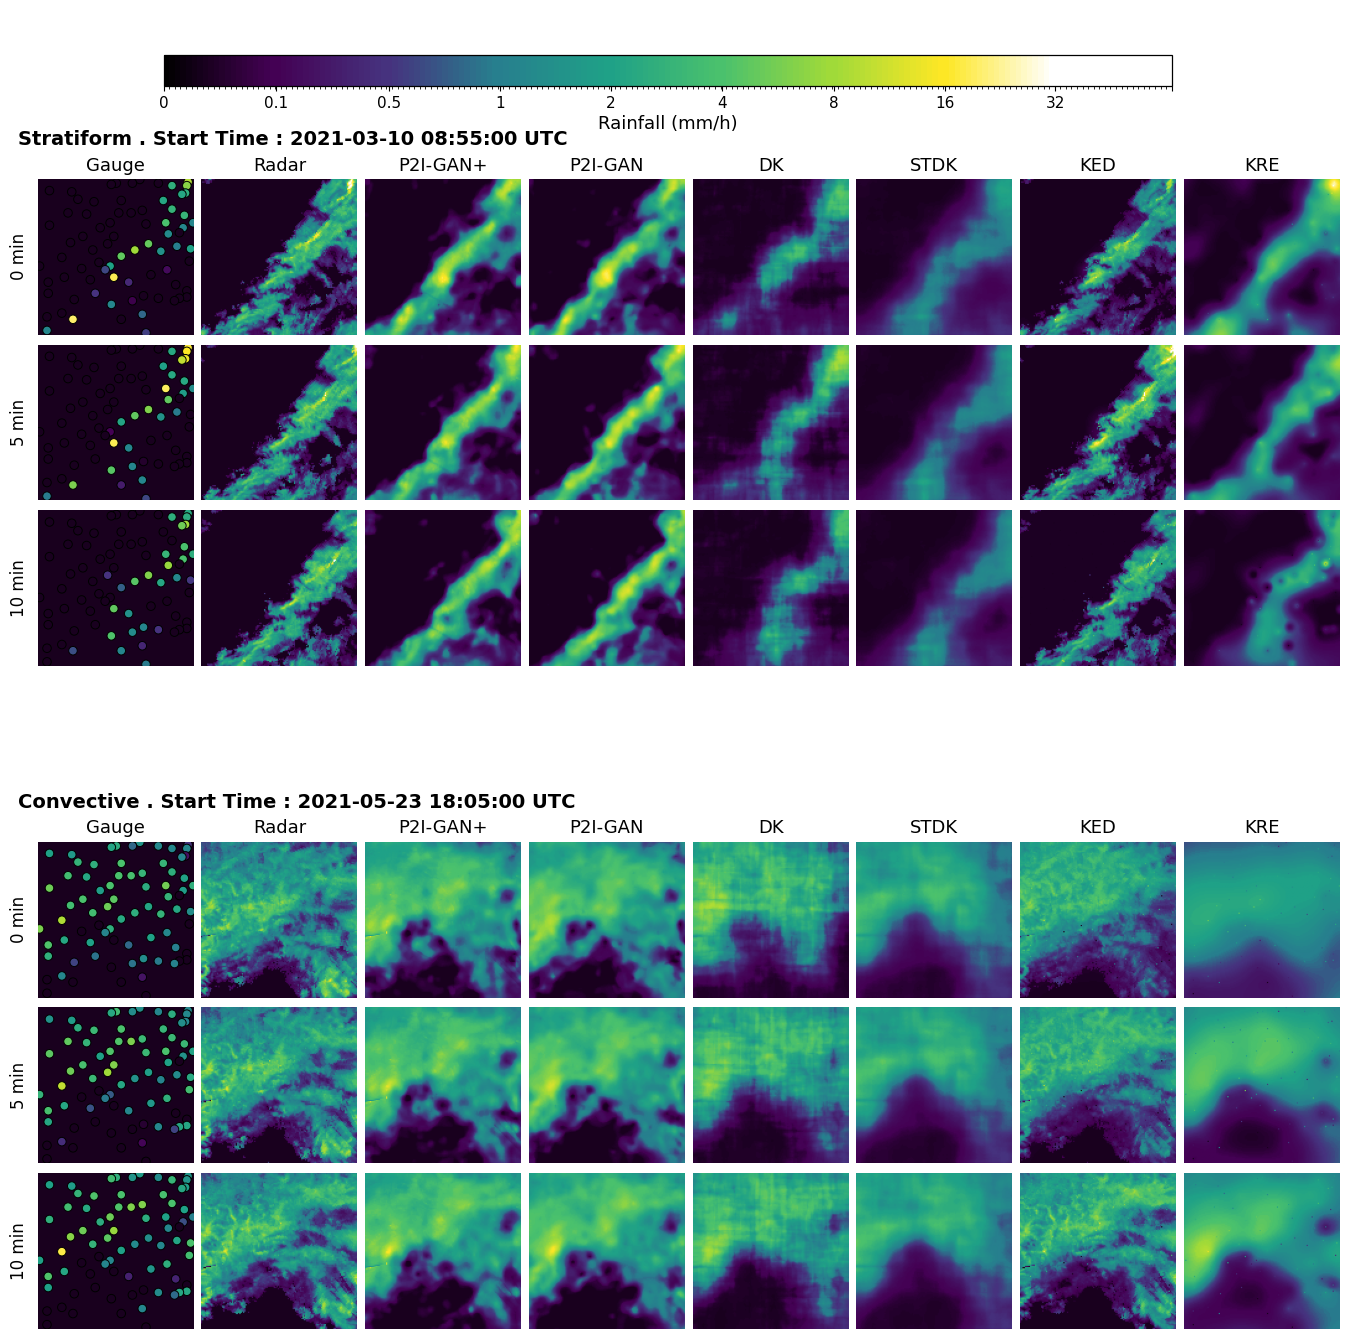

In [166]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


def transform(output):
    return 10 ** (output * 0.0625) * 0.036  # mm/hr 轉換



# ==== 1) 自訂分段 + 平滑色帶（用在所有子圖）====
from matplotlib.colors import ListedColormap, BoundaryNorm

# 主分級（mm/hr）
bounds = [0, 0.1, 0.5, 1, 2, 4, 8, 16, 32, 200]  # 9 段
# colors_log = [
#     "#434a87", "#0000ff", "#00a5c5", "#afd081",
#     "#ffed11", "#f1882c", "#ff0000", "#e72582", "#fffefd"
# ]
colors_log = [
    "#000000",  # 黑色（最低值或背景）
    "#440154",  # 深紫
    "#46327e",  # 靛紫
    "#277f8e",  # 藍綠
    "#1fa187",  # 青綠
    "#4ac16d",  # 草綠
    "#a0da39",  # 黃綠
    "#fde725",  # 黃色
    "#ffffff"   # 白色（最高值或飽和）
]

SUB = 20  # 每段之間做 20 個子區間的線性過渡

def hex_to_rgb01(h):
    h = h.lstrip("#")
    return tuple(int(h[i:i+2], 16)/255.0 for i in (0,2,4))

def lerp(a, b, t):
    return tuple((1-t)*ai + t*bi for ai, bi in zip(a, b))

# 細分邊界
fine_bounds = []
for i in range(len(bounds)-1):
    seg = np.linspace(bounds[i], bounds[i+1], SUB+1, endpoint=False)
    if i == 0: fine_bounds.extend(seg.tolist())
    else:      fine_bounds.extend(seg[1:].tolist())
fine_bounds.append(bounds[-1])
fine_bounds = np.asarray(fine_bounds, float)

# 平滑過渡顏色
rgb_base = [hex_to_rgb01(h) for h in colors_log]
grad_colors = []
for i in range(len(rgb_base)-1):
    c0, c1 = rgb_base[i], rgb_base[i+1]
    for k in range(SUB):
        t = k / float(SUB-1)
        grad_colors.append(lerp(c0, c1, t))
grad_colors.append(rgb_base[-1])  # 最終色
while len(grad_colors) < len(fine_bounds) - 1:
    grad_colors.append(rgb_base[-1])

cmap = ListedColormap(grad_colors, name=f"seg{SUB}_smooth")
norm = BoundaryNorm(fine_bounds, cmap.N, clip=True)

# 讀 mask
mask_path = r"C:\Users\n2000\Downloads\Evaluation\rain_gauge_mask_128_train.txt"
mask = np.loadtxt(mask_path)
# 裁中間 123×123
H, W = mask.shape
ch, cw = 126, 126
sh, sw = (H - ch) // 2, (W - cw) // 2
mask = mask[sh:sh+ch, sw:sw+cw]


mask_points = np.argwhere(mask == 1)  # y, x 座標（row, col）

# 指定資料夾

ffolders = {
    "Radar":   r"C:\Users\n2000\Downloads\Evaluation\figs\merge_radar_gauge_val_10\a_radar_input",
    "Gauge":   r"C:\Users\n2000\Downloads\Evaluation\figs\merge_radar_gauge_val_10\a_gauge_input",
    "P2I-GAN+":      r"C:\Users\n2000\Downloads\Evaluation\figs\merge_radar_gauge_val_10\merge_basepos_val",
    "P2I-GAN":    r"C:\Users\n2000\Downloads\Evaluation\figs\merge_radar_gauge_val_10\merge_base_val",
    "DK":        r"C:\Users\n2000\Downloads\Evaluation\figs\merge_radar_gauge_val_10\merge_dk_val",
    "STDK":     r"C:\Users\n2000\Downloads\Evaluation\figs\merge_radar_gauge_val_10\merge_stdk_val",
    "KED":      r"C:\Users\n2000\Downloads\Evaluation\figs\merge_radar_gauge_val_10\c_ked",
    "KRE":     r"C:\Users\n2000\Downloads\Evaluation\figs\merge_radar_gauge_val_10\c_kre"
}


# ====== 統一 colorbar + 兩事件上下排列 + 各自粗框標題（單張圖, 輸出 PDF） ======
import os, numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

method_order = ["Gauge", "Radar", "P2I-GAN+", "P2I-GAN", "DK", "STDK", "KED", "KRE"]

# === 假設你已有 cmap, norm, mask, mask_points, transform, ffolders, method_order 等 ===

events = [
    {"event_id": 2,  "select_idx": [131, 132, 133],
     "title": "Stratiform . Start Time : 2021-03-10 08:55:00 UTC"},
    {"event_id": 6, "select_idx": [85, 86, 87],
     "title": "Convective . Start Time : 2021-05-23 18:05:00 UTC"},
]

def load_event_images(event_id, select_idx):
    rain_str = f"rain{event_id}"
    sample_folder = os.path.join(ffolders["Gauge"], rain_str)
    all_pngs = sorted([f for f in os.listdir(sample_folder) if f.lower().endswith('.png')],
                      key=lambda x: int(os.path.splitext(x)[0]))
    imgs = []
    for method in method_order:
        folder = os.path.join(ffolders[method], rain_str)
        frames = []
        for idx in select_idx:
            path = os.path.join(folder, all_pngs[idx])
            arr = np.array(Image.open(path).convert('F')).astype(np.float32) / 3.0
            arr = transform(arr)
            H, W = arr.shape
            ch, cw = 126, 126
            sh, sw = (H - ch)//2, (W - cw)//2
            frames.append(arr[sh:sh+ch, sw:sw+cw])
        imgs.append(frames)
    return np.array(imgs)

def draw_block(ax_grid, images, select_idx, minutes_per_step=5, use_select_as_minutes=False):
    n_method = len(method_order)
    n_time   = len(select_idx)
    last_im = None
    for t in range(n_time):
        for m in range(n_method):
            ax = ax_grid[t, m]
            last_im = ax.imshow(images[m, t], cmap=cmap, norm=norm)

            # 不要用 ax.axis('off')，改成只隱藏刻度與邊框
            ax.set_xticks([]); ax.set_yticks([])
            for s in ax.spines.values():
                s.set_visible(False)

            if method_order[m] == "Gauge":
                vals = images[m, t][mask == 1]
                ax.scatter(mask_points[:,1], mask_points[:,0],
                           c=vals, cmap=cmap, norm=norm,
                           s=38, edgecolors='black', linewidths=0.7, zorder=5)

            if t == 0:
                ax.set_title(method_order[m], fontsize=13)

            # 左側加時間標籤（畫在軸座標外側，確保不會被隱藏）
            if m == 0:
                if use_select_as_minutes:
                    time_label = f"{select_idx[t]} min"
                else:
                    time_label = f"{t*minutes_per_step} min"
                ax.text(-0.12, 0.5, time_label, transform=ax.transAxes,
                    ha='center', va='center', fontsize=12, rotation=90)


    return last_im


# === 設定畫布 ===
ncols = len(method_order)
nrows_each = len(events[0]["select_idx"])

# 每個事件：1 列標題 + 多列圖片
total_rows = (nrows_each + 1) * len(events)

fig = plt.figure(figsize=(2.1*ncols, 1.9*total_rows))
gs  = GridSpec(nrows=total_rows, ncols=ncols, figure=fig,
               top=0.93, bottom=0.06, wspace=0.05, hspace=0.02)

# === colorbar ===
from matplotlib.cm import ScalarMappable
sm = ScalarMappable(cmap=cmap, norm=norm); sm.set_array([])
cbar_ax = fig.add_axes([0.20, 0.88, 0.60, 0.02])
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal', ticks=bounds)
tick_labels = [f"{b:g}" for b in bounds[:-1]] + [""]
cbar.set_ticklabels(tick_labels)
cbar.set_label("Rainfall (mm/h)", fontsize=13, labelpad=3)
cbar.ax.tick_params(labelsize=11)

# === 畫每個事件 ===
row_cursor = 0
for e in events:
    # 標題列
    ax_title = fig.add_subplot(gs[row_cursor, :])
    ax_title.axis("off")
    ax_title.text(-0.015, 0.2, e["title"],
              fontsize=14, fontweight="bold", ha="left", va="center",
              transform=ax_title.transAxes)

    row_cursor += 1

   # 圖片列
    ax_grid = np.empty((nrows_each, ncols), dtype=object)
    for r in range(nrows_each):
        for c in range(ncols):
            ax_grid[r, c] = fig.add_subplot(gs[row_cursor + r, c])

    # 繪製圖像
    imgs = load_event_images(e["event_id"], e["select_idx"])
    _ = draw_block(ax_grid, imgs, e["select_idx"])

    row_cursor += nrows_each


plt.tight_layout(rect=[0, 0, 1, 0.7])
fig.savefig("two_events_stacked_titles.pdf", format="pdf", bbox_inches="tight")
# plt.close(fig)


有效點數 = 20


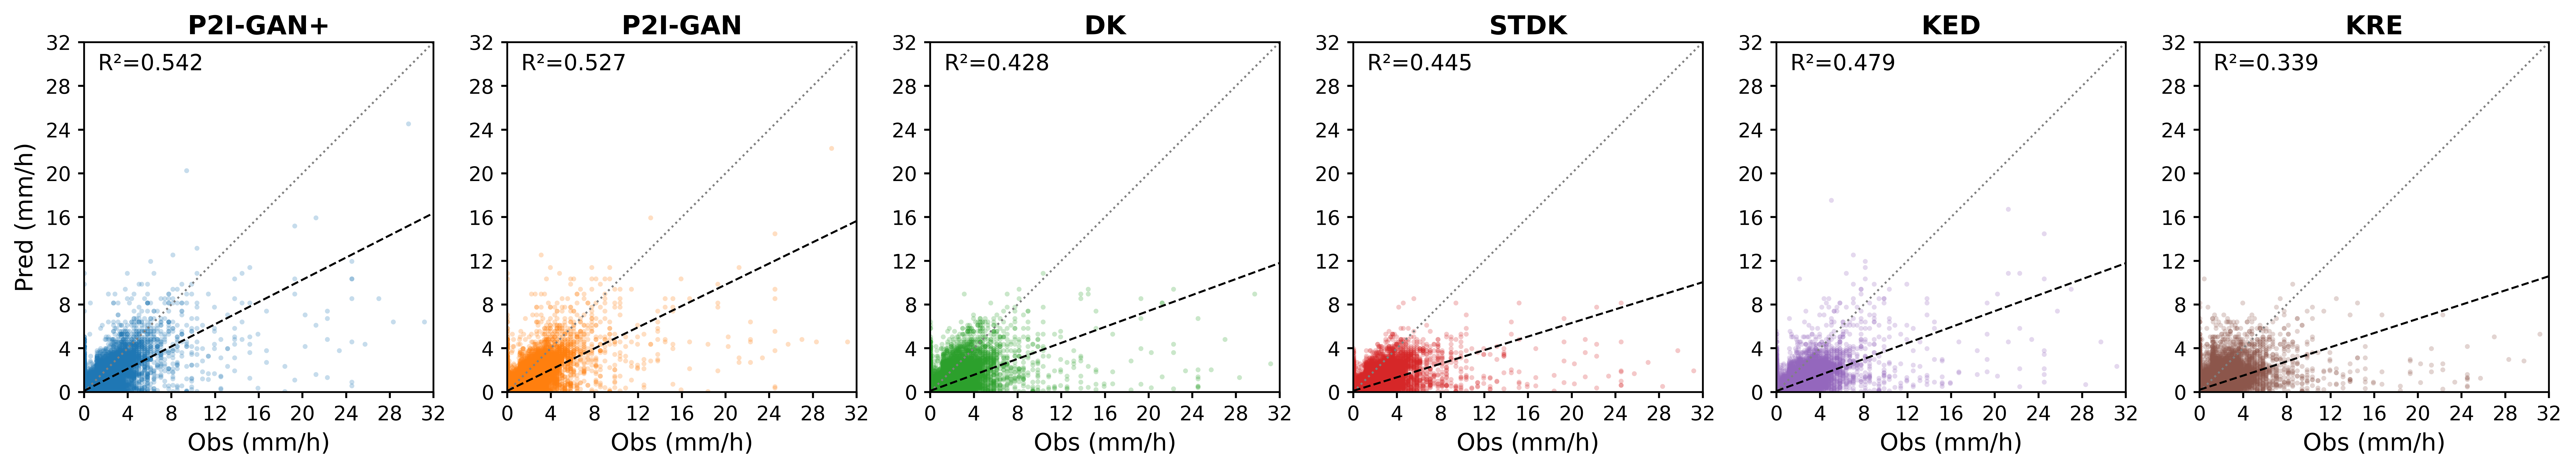

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import os
def transform(output):
    return 10 ** (output * 0.0625) * 0.036


QQ_COLORS = ['#1f77b4', '#ff7f0e', '#2ca02c',
             '#d62728', '#9467bd', '#8c564b']

def qqplot_multi_row_binned(pred_list, true, labels,
                            colors=QQ_COLORS, figsize=(18,3), dpi=300,
                            bulk_bins=30,      # 0~Q99 分成 30 箱：顯示散佈（以統計點）
                            tail_q=(0.99,0.995,0.997,0.999,0.9995,0.9999,0.99999, 0.99995),  # Q99 以上的強化分位
                            xticks=(0,4,8,12,16,20,24,28,32), yticks=(0,4,8,12,16,20,24,28,32),
                            lim=(0,12), point_size=28):

    n = len(pred_list)
    fig, axes = plt.subplots(1, n, figsize=figsize, dpi=dpi)

    true_flat = np.asarray(true, np.float64).ravel()
    true_flat = true_flat[np.isfinite(true_flat)]

    # —— 共同的 1:1 對角參考用 —— #
    x1 = np.linspace(lim[0], lim[1], 200)

    # —— 先算 bulk 的分箱邊界（0~Q99） —— #
    q99 = np.quantile(true_flat, 0.99)
    bulk_edges = np.linspace(true_flat.min(), q99, bulk_bins+1)

    for i, (pred, label) in enumerate(zip(pred_list, labels)):
        ax = axes[i]
        pf = np.asarray(pred, np.float64).ravel()
        mask = np.isfinite(pf)
        pf = pf[mask]; tf = true_flat[:pf.size]  # 對齊長度（保險）

        # 1) bulk：依 true 的值做分箱 → 每箱取 true/ pred 的中位數與 IQR
        inds = np.clip(np.digitize(tf, bulk_edges)-1, 0, bulk_bins-1)
        q_true_med, q_pred_med, q_pred_q25, q_pred_q75 = [], [], [], []
        for b in range(bulk_bins):
            sel = (inds == b)
            if sel.any():
                t_box = tf[sel]; p_box = pf[sel]
                q_true_med.append(np.median(t_box))
                q_pred_med.append(np.median(p_box))
                q_pred_q25.append(np.quantile(p_box, 0.25))
                q_pred_q75.append(np.quantile(p_box, 0.75))
        q_true_med = np.array(q_true_med); q_pred_med = np.array(q_pred_med)
        q_pred_q25 = np.array(q_pred_q25); q_pred_q75 = np.array(q_pred_q75)

        # 2) tails：Q99 以上用更密的分位點
        tail_q = np.array(tail_q)
        q_true_tail = np.quantile(tf, tail_q[tail_q > 0.99])
        q_pred_tail = np.quantile(pf, tail_q[tail_q > 0.99])

        # 3) 回歸線（用 bulk+tail 的代表點）
        x_fit = np.concatenate([q_true_med, q_true_tail])
        y_fit = np.concatenate([q_pred_med, q_pred_tail])
        slope, intercept, r, _, _ = stats.linregress(x_fit, y_fit)

        # —— 繪圖 —— #
        # (a) 1:1 線與回歸線
        ax.plot(x1, x1, color='gray', ls=':', lw=1.0)
        ax.plot(x1, intercept + slope*x1, 'k--', lw=1.0)

        # (b) bulk：中位點 + IQR（豎線）
        ax.vlines(q_true_med, q_pred_q25, q_pred_q75,
                  color=colors[i], alpha=0.35, lw=2)
        ax.scatter(q_true_med, q_pred_med, s=point_size,
                   color=colors[i], alpha=0.85, edgecolors='none')

        # (c) tails：用鑽石形標出
        ax.scatter(q_true_tail, q_pred_tail, s=point_size*1.2,
                   color=colors[i], marker='D', alpha=0.9, edgecolors='none')

        # 標題與座標系
        ax.set_title(label, fontsize=14, fontweight='bold', pad=4)
        ax.set_xlim(*lim); ax.set_ylim(*lim); ax.set_aspect('equal', 'box')
        ax.set_xticks(xticks); ax.set_yticks(yticks)
        ax.tick_params(axis='both', labelsize=11, width=1.0, length=3)
        ax.grid(False)
        ax.text(0.05, 0.90, f"R²={r**2:.3f}", transform=ax.transAxes, fontsize=11)

        # 提示：灰底框出 Q99 區域（可視化極端所在）
        ax.add_patch(Rectangle((q99, lim[0]), lim[1]-q99, lim[1]-lim[0],
                               fill=False, ec='gray', lw=0.8, ls='--', alpha=0.7))

        # 標籤：只保留 x 標籤；y 僅刻度不文字
        ax.set_xlabel("Obs Quantiles (mm/h)", fontsize=12, fontweight='bold')
        if i == 0:
            ax.set_ylabel("Pred Quantiles (mm/h)", fontsize=12, fontweight='bold')
        else:
            ax.set_ylabel(None)

    plt.tight_layout(pad=1.0)
    plt.savefig(f'qq.png', bbox_inches='tight')
    plt.show()


RES_COLORS = ['#1f77b4', '#ff7f0e', '#2ca02c',
              '#d62728', '#9467bd', '#8c564b']

def residual_multi_row(pred_list, true, labels,
                       colors=RES_COLORS,
                       figsize=(21, 3), dpi=600,
                       lim_x=(0, 32), lim_y=(-24, 8),
                       xticks=(0,4,8,12,16,20,24,28,32),
                       yticks=(-24,-20,-16,-12,-8,-4,0,4,8),
                       max_points=100000, alpha=0.25, s=6,
                       seed=42, save_path=None):
    """
    畫出多組模型的殘差圖（Residual Plot）
    橫軸：True，縱軸：Residual = Pred - True
    """

    rng = np.random.default_rng(seed)
    n = len(pred_list)
    fig, axes = plt.subplots(1, n, figsize=figsize, dpi=dpi)

    # 展平成 1D，僅保留有效值
    tf = np.asarray(true, np.float64).ravel()
    mask_t = np.isfinite(tf)
    tf = tf[mask_t]

    for i, (pred, label) in enumerate(zip(pred_list, labels)):
        ax = axes[i]
        pf = np.asarray(pred, np.float64).ravel()
        pf = pf[mask_t[:pf.size]] if pf.size <= mask_t.size else pf  # 對齊
        m = np.isfinite(pf) & np.isfinite(tf[:pf.size])
        x = tf[:pf.size][m]
        y = pf[m] - tf[:pf.size][m]  # 殘差

        # 抽樣（避免太多點）
        if x.size > max_points:
            idx = rng.choice(x.size, size=max_points, replace=False)
            x, y = x[idx], y[idx]

        # 繪圖
        ax.scatter(x, y, s=s, alpha=alpha, color=colors[i],
           edgecolors='none', rasterized=True, zorder=1)


        # 回歸趨勢線（若點夠多）
        if x.size >= 2:
            slope, intercept, r, _, _ = stats.linregress(x, y)
            x_line = np.linspace(lim_x[0], lim_x[1], 200)
            ax.plot(x_line, np.zeros_like(x_line), color='gray', ls=':', lw=1.0)  # baseline
            ax.plot(x_line, intercept + slope * x_line, 'k--', lw=1.0)            # trend
            # ax.text(0.04, 0.92, f"R²={r**2:.3f}", transform=ax.transAxes, fontsize=11)

        # 座標設定
        ax.set_title(label, fontsize=13, fontweight='bold', pad=4)
        ax.set_xlim(*lim_x); ax.set_ylim(*lim_y)
        ax.set_xticks(xticks); ax.set_yticks(yticks)
        ax.tick_params(axis='both', labelsize=10, width=1.0, length=3)
        ax.grid(False)
        ax.axhline(0, color='black', lw=1.0, ls='--')

        if i == 0:
            ax.set_ylabel("Residual (Pred - Obs, mm/h)", fontsize=12)
        ax.set_xlabel("Obs (mm/h)", fontsize=12)

    plt.tight_layout(pad=1.0)
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()


SCATTER_COLORS = ['#1f77b4', '#ff7f0e', '#2ca02c',
                  '#d62728', '#9467bd', '#8c564b']

def scatter_multi_row(pred_list, true, labels,
                      colors=SCATTER_COLORS,
                      figsize=(21, 3), dpi=600,
                      lim=(0, 12), xticks=(0,4,8,12,16,20,24,28,32), yticks=(0,4,8,12,16,20,24,28,32),
                      max_points=100000,  # 單圖最多散點（抽樣）
                      alpha=0.25, s=6,    # 透明度與點大小
                      seed=42, save_path=None):
    """
    pred_list : list[np.ndarray]  每組預測 (T,H,W) 或任意形狀
    true      : np.ndarray       真值，形狀與各預測可對齊
    labels    : list[str]        標題
    """

    rng = np.random.default_rng(seed)
    n = len(pred_list)
    fig, axes = plt.subplots(1, n, figsize=figsize, dpi=dpi)

    # 共同 1:1 線的 x
    x1 = np.linspace(lim[0], lim[1], 200)

    # 展平成 1D，僅保留有效值
    tf = np.asarray(true, np.float64).ravel()
    mask_t = np.isfinite(tf)
    tf = tf[mask_t]

    for i, (pred, label) in enumerate(zip(pred_list, labels)):
        ax = axes[i]
        pf = np.asarray(pred, np.float64).ravel()
        pf = pf[mask_t[:pf.size]] if pf.size <= mask_t.size else pf  # 基本對齊
        # 保留共同有限值
        m = np.isfinite(pf) & np.isfinite(tf[:pf.size])
        x = tf[:pf.size][m]
        y = pf[m]

        # 限制視窗範圍內的點以降低外圍極端影響
        in_box = (x >= lim[0]) & (x <= lim[1]) & (y >= lim[0]) & (y <= lim[1])
        x, y = x[in_box], y[in_box]

        # 抽樣
        if x.size > max_points:
            idx = rng.choice(x.size, size=max_points, replace=False)
            x, y = x[idx], y[idx]

        # 散點
        ax.scatter(x, y, s=s, alpha=alpha, color=colors[i],
           edgecolors='none', rasterized=True, zorder=1)


        # 回歸（以抽樣點）
        if x.size >= 2:
            slope, intercept, r, _, _ = stats.linregress(x, y)
            ax.plot(x1, x1, color='gray', ls=':', lw=1.0)                # 1:1
            ax.plot(x1, intercept + slope*x1, 'k--', lw=1.0)             # 回歸
            ax.text(0.04, 0.92, f"R²={r**2:.3f}\nslope={slope:.3f}", transform=ax.transAxes, fontsize=11)
            

        # 軸設定
        ax.set_title(label, fontsize=13, fontweight='bold', pad=4)
        ax.set_xlim(*lim); ax.set_ylim(*lim); ax.set_aspect('equal', 'box')
        ax.set_xticks(xticks); ax.set_yticks(yticks)
        ax.tick_params(axis='both', labelsize=10, width=1.0, length=3)
        ax.grid(False)

        if i == 0:
            ax.set_ylabel("Pred (mm/h)", fontsize=12)
        ax.set_xlabel("Obs (mm/h)", fontsize=12)

    plt.tight_layout(pad=1.0)
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()


# === 讀取 mask ===
mask_path = r"C:\Users\n2000\Downloads\Evaluation\rain_gauge_mask_128_val.txt"
mask = np.loadtxt(mask_path)
mask = mask.astype(bool)
print("有效點數 =", mask.sum())

def load_imgs(folder, sub_prefix="rain"):
    """遞迴掃描 folder 下的 rain0~rain9 子資料夾所有 PNG 檔"""
    frames = []
    # 找出所有子資料夾（名稱以 rain 開頭）
    subfolders = sorted([
        os.path.join(folder, d)
        for d in os.listdir(folder)
        if os.path.isdir(os.path.join(folder, d)) and d.startswith(sub_prefix)
    ])
    if not subfolders:
        print(f"[警告] {folder} 下沒有找到任何 '{sub_prefix}*' 子資料夾。")
        return np.array([])

    for sub in subfolders:
        files = sorted([f for f in os.listdir(sub) if f.lower().endswith('.png')])
        if not files:
            print(f"[警告] {sub} 沒有 PNG 檔。")
            continue

        for fname in files:
            path = os.path.join(sub, fname)
            img = Image.open(path).convert('L')
            w, h = img.size
            arr = np.array(img).astype(np.float32) / 3.0
            arr = transform(arr)
            frames.append(arr[mask])  # 只保留有效像素

    if not frames:
        print(f"[警告] {folder} 沒有任何有效圖片。")
        return np.array([])
    return np.concatenate(frames)



# === 修正資料夾字典（把 "Vaild" 改為 "Valid"） ===
ffolders = {
    "Radar":   r"C:\Users\n2000\Downloads\Evaluation\figs\merge_radar_gauge_val_10\a_radar_input",
    "Gauge":   r"C:\Users\n2000\Downloads\Evaluation\figs\merge_radar_gauge_val_10\a_gauge_input",
    "Valid":   r"C:\Users\n2000\Downloads\Evaluation\figs\merge_radar_gauge_val_10\a_gauge_vaild",
    "P2I-GAN+": r"C:\Users\n2000\Downloads\Evaluation\figs\merge_radar_gauge_val_10\merge_basepos_val",
    "P2I-GAN":  r"C:\Users\n2000\Downloads\Evaluation\figs\merge_radar_gauge_val_10\merge_base_val",
    "DK":       r"C:\Users\n2000\Downloads\Evaluation\figs\merge_radar_gauge_val_10\merge_dk_val",
    "STDK":     r"C:\Users\n2000\Downloads\Evaluation\figs\merge_radar_gauge_val_10\merge_stdk_val",
    "KED":      r"C:\Users\n2000\Downloads\Evaluation\figs\merge_radar_gauge_val_10\c_ked",
    "KRE":      r"C:\Users\n2000\Downloads\Evaluation\figs\merge_radar_gauge_val_10\c_kre"
}


# === 讀檔並根據 mask 過濾 ===
imgs = {name: load_imgs(path) for name, path in ffolders.items()}

# === 設定真值與預測 ===
true = imgs["Valid"]
pred_list = [
    imgs["P2I-GAN+"],
    imgs["P2I-GAN"],
    imgs["DK"],
    imgs["STDK"],
    imgs["KED"],
    imgs["KRE"],
]
labels = ["P2I-GAN+", "P2I-GAN", "DK", "STDK", "KED", "KRE"]

# # 丟進你前面定義好的 qqplot_multi_row（會自動 flatten 做分位比較）
# qqplot_multi_row_binned(pred_list, true, labels, figsize=(21,3), lim=(0,32), dpi=600)

scatter_multi_row(pred_list, true, labels, figsize=(18,3), dpi=600,
                  lim=(0,32), max_points=120000, alpha=0.25, s=6,
                  save_path="scatter_panels.pdf")

# residual_multi_row(pred_list, true, labels,
#                    figsize=(18,3), dpi=600,
#                    save_path="residual_panels.pdf")


In [1]:
from opencc import OpenCC

# 初始化簡體轉繁體轉換器
cc = OpenCC('s2t')

# 讀取原始檔案
input_path = r"C:\Users\n2000\Downloads\Evaluation\sti_method\moonwalk.txt"
with open(input_path, 'r', encoding='utf-8') as f:
    text = f.read()

# 轉換成繁體中文
traditional_text = cc.convert(text)

# 輸出成新檔案
output_path = r"C:\Users\n2000\Downloads\Evaluation\sti_method\moonwalk_traditional.txt"
with open(output_path, 'w', encoding='utf-8') as f:
    f.write(traditional_text)

print("轉換完成，輸出檔案：", output_path)


轉換完成，輸出檔案： C:\Users\n2000\Downloads\Evaluation\sti_method\moonwalk_traditional.txt


In [ ]:
import matplotlib.pyplot as plt

ref = all_data[ref_name]
q = np.linspace(1e-4, 0.999, 400)
ref_q = np.quantile(ref, q)

plt.figure(figsize=(5,5))
plt.plot(ref_q, ref_q, linestyle='--')  # 45° 理想線

for name, x in all_data.items():
    if name == ref_name: 
        continue
    x_q = np.quantile(x, q)
    plt.plot(ref_q, x_q, label=name)

plt.xlabel(f'{ref_name} quantiles (mm/hr)')
plt.ylabel('Method quantiles (mm/hr)')
plt.title('Q–Q vs. reference')
plt.tight_layout()
plt.legend(fontsize=9)
plt.show()


In [8]:
import os
import numpy as np
from PIL import Image
import matplotlib as mpl
import matplotlib.pyplot as plt

# -------- Plot style (IEEE-like) --------
mpl.rcParams.update({
    "font.size": 9, "axes.titlesize": 10, "axes.labelsize": 9,
    "xtick.labelsize": 8, "ytick.labelsize": 8, "legend.fontsize": 8,
    "axes.linewidth": 0.9, "lines.linewidth": 1.0, "pdf.fonttype": 42, "ps.fonttype": 42
})

# -------- I/O & helpers --------
def transform(x):  # 灰階 → mm/h
    return 10 ** (x * 0.0625) * 0.036

def load_imgs(folder, event_range=range(10)):
    frames = []
    for event_id in event_range:
        d = os.path.join(folder, f"rain{event_id}")
        files = sorted([f for f in os.listdir(d) if f.lower().endswith('.png')],
                       key=lambda x: int(os.path.splitext(x)[0]))
        for f in files:
            arr = np.array(Image.open(os.path.join(d, f)).convert('L'), np.float32) / 3.0
            frames.append(transform(arr))
    return np.stack(frames)  # [T,H,W]

def load_mask(mask_path):
    return np.loadtxt(mask_path).astype(bool)  # [H,W]

def mae_series(pred, truth, mask=None):
    """
    回傳逐幀 MAE: [T]
    mask=None → 全場；mask=bool[H,W] → 僅在站點像元計算
    """
    assert pred.shape == truth.shape and pred.ndim == 3
    T, H, W = pred.shape
    diff = np.abs(pred - truth)

    if mask is None:
        # 全場
        return diff.reshape(T, -1).mean(axis=1)

    # 站點遮罩
    m = np.asarray(mask, dtype=bool)
    if m.shape != (H, W):
        raise ValueError(f"mask shape {m.shape} != {(H, W)}")
    m_flat = m.ravel()
    if m_flat.sum() == 0:
        return np.full(T, np.nan, dtype=np.float32)

    diff_flat = diff.reshape(T, -1)
    # 若資料可能含 NaN，可改成 np.nanmean
    return diff_flat[:, m_flat].mean(axis=1)

# -------- Paths --------
folders = {
    "Valid": r"C:\Users\n2000\Downloads\Evaluation\figs\merge_radar_gauge_val_10\a_gauge_vaild",
    "Base+": r"C:\Users\n2000\Downloads\Evaluation\figs\merge_radar_gauge_val_10\merge_baseplusw_val",
    "Base":  r"C:\Users\n2000\Downloads\Evaluation\figs\merge_radar_gauge_val_10\merge_base_val",
    "DK":    r"C:\Users\n2000\Downloads\Evaluation\figs\merge_radar_gauge_val_10\merge_dk_val",
    "STDK":  r"C:\Users\n2000\Downloads\Evaluation\figs\merge_radar_gauge_val_10\merge_stdk_val",
    "KED":   r"C:\Users\n2000\Downloads\Evaluation\figs\merge_radar_gauge_val_10\c_ked",
}
mask_path = r"C:\Users\n2000\Downloads\Evaluation\rain_gauge_mask_128_val.txt"

# -------- Load --------
mask  = load_mask(mask_path)
imgs  = {name: load_imgs(path) for name, path in folders.items()}
min_T = min(v.shape[0] for v in imgs.values())
for k in imgs: imgs[k] = imgs[k][:min_T]

truth = imgs["Valid"]
methods = ["Base+", "Base", "DK", "STDK", "KED"]
colors  = ["#ff7f0e", "#1f77b4", "#2ca02c", "#d62728", "#9467bd"]  # 可換

# -------- Compute per-frame MAE --------
pairs = {}  # method -> (x_site_mae, y_field_mae)
for m in methods:
    pred = imgs[m]
    mae_site  = mae_series(pred, truth, mask=mask)   # x
    mae_field = mae_series(pred, truth, mask=None)   # y
    ok = np.isfinite(mae_site) & np.isfinite(mae_field)
    pairs[m] = (mae_site[ok], mae_field[ok])

# 決定座標上限（所有方法的最大 MAE 取 99.5 分位避免極端值）
all_x = np.concatenate([pairs[m][0] for m in methods])
all_y = np.concatenate([pairs[m][1] for m in methods])
lim = float(np.nanquantile(np.concatenate([all_x, all_y]), 0.995))
lim = max(lim, 1.0)  # 至少 1 mm/h
xmax = ymax = np.ceil(lim * 10) / 10.0  # 取到一位小數

# -------- Plot 1×N panels --------
fig, axes = plt.subplots(1, len(methods), figsize=(2.1*len(methods), 2.2), dpi=300, constrained_layout=True)

xticks = (0, 4, 8, 12)
yticks = (0, 4, 8, 12)
lim = (0, 12)

for ax, m, c in zip(axes, methods, colors):
    x, y = pairs[m]
    ax.scatter(x, y, s=10, c=c, alpha=0.45, edgecolors='none')

    # y = x 參考線
    ax.plot(lim, lim, ls='--', color='k', lw=1.0)

    # 固定座標與刻度
    ax.set_xlim(lim)
    ax.set_ylim(lim)
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_aspect('equal', adjustable='box')

    ax.set_title(m, pad=2, fontweight='bold')
    if ax is axes[0]:
        ax.set_ylabel("MAE (mm/h)")
    ax.set_xlabel("Site MAE (mm/h)")
    ax.tick_params(width=0.9, length=3)


plt.savefig("mae_vs_site_mae_panels.pdf", bbox_inches="tight")
plt.savefig("mae_vs_site_mae_panels.png", dpi=600, bbox_inches="tight")
plt.show()


FileNotFoundError: [WinError 3] 系統找不到指定的路徑。: 'C:\\Users\\n2000\\Downloads\\Evaluation\\figs\\merge_radar_gauge_val_10\\merge_baseplusw_val\\rain0'

In [9]:
import os
import numpy as np
from PIL import Image
import matplotlib as mpl
import matplotlib.pyplot as plt

# -------- Plot style (IEEE-like) --------
mpl.rcParams.update({
    "font.size": 9, "axes.titlesize": 10, "axes.labelsize": 9,
    "xtick.labelsize": 8, "ytick.labelsize": 8, "legend.fontsize": 8,
    "axes.linewidth": 0.9, "lines.linewidth": 1.0, "pdf.fonttype": 42, "ps.fonttype": 42
})

# -------- I/O & helpers --------
def transform(x):  # 灰階 → mm/h
    return 10 ** (x * 0.0625) * 0.036

def load_imgs(folder, event_range=range(10)):
    frames = []
    for event_id in event_range:
        d = os.path.join(folder, f"rain{event_id}")
        files = sorted([f for f in os.listdir(d) if f.lower().endswith('.png')],
                       key=lambda x: int(os.path.splitext(x)[0]))
        for f in files:
            arr = np.array(Image.open(os.path.join(d, f)).convert('L'), np.float32) / 3.0
            frames.append(transform(arr))
    return np.stack(frames)  # [T,H,W]

def load_mask(mask_path):
    return np.loadtxt(mask_path).astype(bool)  # [H,W]

def mae_series(pred, truth, mask=None):
    """
    回傳逐幀 MAE: [T]
    mask=None → 全場；mask=bool[H,W] → 僅在站點像元計算
    """
    assert pred.shape == truth.shape and pred.ndim == 3
    T, H, W = pred.shape
    diff = np.abs(pred - truth)

    if mask is None:
        # 全場
        return diff.reshape(T, -1).mean(axis=1)

    # 站點遮罩
    m = np.asarray(mask, dtype=bool)
    if m.shape != (H, W):
        raise ValueError(f"mask shape {m.shape} != {(H, W)}")
    m_flat = m.ravel()
    if m_flat.sum() == 0:
        return np.full(T, np.nan, dtype=np.float32)

    diff_flat = diff.reshape(T, -1)
    # 若資料可能含 NaN，可改成 np.nanmean
    return diff_flat[:, m_flat].mean(axis=1)

# -------- Paths --------
folders = {
    "Valid": r"C:\Users\n2000\Downloads\Evaluation\figs\merge_radar_gauge_val_10\a_gauge_vaild",
    "Base+": r"C:\Users\n2000\Downloads\Evaluation\figs\merge_radar_gauge_val_10\merge_baseplusw_val",
    "Base":  r"C:\Users\n2000\Downloads\Evaluation\figs\merge_radar_gauge_val_10\merge_base_val",
    "DK":    r"C:\Users\n2000\Downloads\Evaluation\figs\merge_radar_gauge_val_10\merge_dk_val",
    "STDK":  r"C:\Users\n2000\Downloads\Evaluation\figs\merge_radar_gauge_val_10\merge_stdk_val",
    "KED":   r"C:\Users\n2000\Downloads\Evaluation\figs\merge_radar_gauge_val_10\c_ked",
}
mask_path = r"C:\Users\n2000\Downloads\Evaluation\rain_gauge_mask_128_val.txt"

# -------- Load --------
mask  = load_mask(mask_path)
imgs  = {name: load_imgs(path) for name, path in folders.items()}
min_T = min(v.shape[0] for v in imgs.values())
for k in imgs: imgs[k] = imgs[k][:min_T]

truth = imgs["Valid"]
methods = ["Base+", "Base", "DK", "STDK", "KED"]
colors  = ["#ff7f0e", "#1f77b4", "#2ca02c", "#d62728", "#9467bd"]  # 可換

# -------- Compute per-frame MAE --------
pairs = {}  # method -> (x_site_mae, y_field_mae)
for m in methods:
    pred = imgs[m]
    mae_site  = mae_series(pred, truth, mask=mask)   # x
    mae_field = mae_series(pred, truth, mask=None)   # y
    ok = np.isfinite(mae_site) & np.isfinite(mae_field)
    pairs[m] = (mae_site[ok], mae_field[ok])

# 決定座標上限（所有方法的最大 MAE 取 99.5 分位避免極端值）
all_x = np.concatenate([pairs[m][0] for m in methods])
all_y = np.concatenate([pairs[m][1] for m in methods])
lim = float(np.nanquantile(np.concatenate([all_x, all_y]), 0.995))
lim = max(lim, 1.0)  # 至少 1 mm/h
xmax = ymax = np.ceil(lim * 10) / 10.0  # 取到一位小數

# -------- Plot 1×N panels --------
fig, axes = plt.subplots(1, len(methods), figsize=(2.1*len(methods), 2.2), dpi=300, constrained_layout=True)

xticks = (0, 4, 8, 12)
yticks = (0, 4, 8, 12)
lim = (0, 12)

# 在檔案前面加入
def overlay_quantile_rings(ax, x, y,
                           qs=(0.99, 0.999, 0.9999),
                           sizes=(36, 46, 58),
                           alphas=(0.50, 0.75, 1.00),
                           edge='k', lw=(1.0, 1.2, 1.5)):
    """
    在散點上方疊加「空心圓」標示尾端點：
      - 尾端定義：x>=Qx(q) 或 y>=Qy(q)（逐個 q）
      - 每個 q 使用不同大小/透明度/線寬
    """
    for q, s, a, w in zip(qs, sizes, alphas, lw):
        qx, qy = np.quantile(x, q), np.quantile(y, q)
        m = (x >= qx) | (y >= qy)
        if m.any():
            ax.scatter(x[m], y[m],
                       s=s, facecolors='none', edgecolors=edge,
                       linewidths=w, alpha=a, zorder=4,
                       clip_on=True)

for ax, m, c in zip(axes, methods, colors):
    x, y = pairs[m]

    # 1) 全部點（底層）
    ax.scatter(x, y, s=10, c=c, alpha=0.35, edgecolors='none', zorder=1)

    # 2) 疊加：Q99 / Q99.9 / Q99.99 尾端點（同樣是圓圈與透明度控制）
    overlay_quantile_rings(ax, x, y,
                           qs=(0.99, 0.999, 0.9999),
                           sizes=(36, 46, 58),
                           alphas=(0.50, 0.75, 1.00),
                           edge='k', lw=(0.9, 1.1, 1.4))

    # 參考線與座標設定
    ax.plot(lim, lim, ls='--', color='k', lw=1.0, zorder=2)
    ax.set_xlim(lim); ax.set_ylim(lim)
    ax.set_xticks(xticks); ax.set_yticks(yticks)
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(m, pad=2, fontweight='bold')
    if ax is axes[0]:
        ax.set_ylabel("MAE (mm/h)")
    ax.set_xlabel("Site MAE (mm/h)")
    ax.tick_params(width=0.9, length=3)


plt.savefig("mae_vs_site_mae_panels.pdf", bbox_inches="tight")
plt.savefig("mae_vs_site_mae_panels.png", dpi=600, bbox_inches="tight")
plt.show()


FileNotFoundError: [WinError 3] 系統找不到指定的路徑。: 'C:\\Users\\n2000\\Downloads\\Evaluation\\figs\\merge_radar_gauge_val_10\\merge_baseplusw_val\\rain0'